# **Taxi Trip Dataset Analysis**

This project analyzes a dataset of approximately 500,000 taxi trips to explore traffic conditions and their impact on trip characteristics. Initially assumed to represent New York City taxi trips—due to features like distances to landmarks (e.g., JFK, LGA, Statue of Liberty)—the dataset comprises 26 columns, including pickup and dropoff locations (latitude/longitude), times (`pickup_datetime`, `year`, `month`, `day`, `hour`, `weekday`), fare amounts, passenger counts, total trip distances, distances to major landmarks (`jfk_dist`, `ewr_dist`, `lga_dist`, `sol_dist`, `nyc_dist`), and categorical features such as `Car Condition`, `Weather`, and `Traffic Condition`. However, exploratory data analysis (EDA) revealed that the geographical coordinates span globally (e.g., Brazil, off the coast of Africa, Atlantic Ocean), not solely NYC, despite valid ranges (-90 to 90 for latitude, - torch to 180 for longitude). Additionally, significant outliers and a high prevalence of zero values (e.g., zero fares, zero landmark distances) suggest data quality issues or a broader scope than anticipated. Through EDA, we aim to uncover patterns in traffic conditions across time, location, and other factors, assess their influence on fare amounts, trip distances, and passenger behavior, and address discrepancies to refine our understanding of the dataset’s true context.

# 1. Importing Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from IPython.display import display
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# 2. Loading the Dataset

In [70]:
data = pd.read_csv('./final_internship_data.csv')
data.head()

User ID          User Name       Driver Name Car Condition Weather  \
0  KHVrEVlD     Kimberly Adams        Amy Butler     Very Good   windy   
1  lPxIuEri       Justin Tapia  Hannah Zimmerman     Excellent  cloudy   
2  gsVN8JLS    Elizabeth Lopez    Amanda Jackson           Bad  stormy   
3  9I7kWFgd      Steven Wilson          Amy Horn     Very Good  stormy   
4  8QN5ZaGN  Alexander Andrews  Cassandra Larson           Bad  stormy   

   Traffic Condition                            key  fare_amount  \
0  Congested Traffic    2009-06-15 17:26:21.0000001          4.5   
1       Flow Traffic    2010-01-05 16:52:16.0000002         16.9   
2  Congested Traffic   2011-08-18 00:35:00.00000049          5.7   
3       Flow Traffic    2012-04-21 04:30:42.0000001          7.7   
4  Congested Traffic  2010-03-09 07:51:00.000000135          5.3   

       pickup_datetime  pickup_longitude  ...  month  weekday  year  \
0  2009-06-15 17:26:21         -1.288826  ...      6        0  2009   
1  2010-01-05 16:52:16         -1.291824  ...      1        1  2010   
2  2011-08-18 00:35:00         -1.291242  ...      8        3  2011   
3  2012-04-21 04:30:42         -1.291319  ...      4        5  2012   
4  2010-03-09 07:51:00         -1.290987  ...      3        1  2010   

    jfk_dist   ewr_dist   lga_dist   sol_dist   nyc_dist  distance   bearing  
0  20.265840  55.176046  14.342611  34.543548  27.572573  1.030764 -2.918897  
1  44.667679  31.832358  23.130775  15.125872   8.755732  8.450134 -0.375217  
2  43.597686  33.712082  19.865289  17.722624   9.847344  1.389525  2.599961  
3  42.642965  32.556289  21.063132  15.738963   7.703421  2.799270  0.133905  
4  43.329953  39.406828  15.219339  23.732406  15.600745  1.999157 -0.502703  

[5 rows x 26 columns]

# 3. Exploring the Dataset

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   User ID            500000 non-null  object 
 1   User Name          500000 non-null  object 
 2   Driver Name        500000 non-null  object 
 3   Car Condition      500000 non-null  object 
 4   Weather            500000 non-null  object 
 5   Traffic Condition  500000 non-null  object 
 6   key                500000 non-null  object 
 7   fare_amount        500000 non-null  float64
 8   pickup_datetime    500000 non-null  object 
 9   pickup_longitude   500000 non-null  float64
 10  pickup_latitude    500000 non-null  float64
 11  dropoff_longitude  499995 non-null  float64
 12  dropoff_latitude   499995 non-null  float64
 13  passenger_count    500000 non-null  int64  
 14  hour               500000 non-null  int64  
 15  day                500000 non-null  int64  
 16  mo

# 4. Handling Missing Values

During our initial exploration, we assessed the dataset for missing values across all features. The results are as follows:

- `User ID`, `User Name`, `Driver Name`, `Car Condition`, `Weather`, `Traffic Condition`, `key`, `fare_amount`, `pickup_datetime`, `pickup_longitude`, `pickup_latitude`, `passenger_count`, `hour`, `day`, `month`, `weekday`, `year`: **0 missing values**
- `dropoff_longitude`, `dropoff_latitude`, `jfk_dist`, `ewr_dist`, `lga_dist`, `sol_dist`, `nyc_dist`, `distance`, `bearing`: **5 missing values each**


In [72]:
data.isnull().sum()

User ID              0
User Name            0
Driver Name          0
Car Condition        0
Weather              0
Traffic Condition    0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
hour                 0
day                  0
month                0
weekday              0
year                 0
jfk_dist             5
ewr_dist             5
lga_dist             5
sol_dist             5
nyc_dist             5
distance             5
bearing              5
dtype: int64

Given the small number of affected rows (5 out of potentially thousands), their removal is unlikely to significantly impact the dataset’s overall integrity. Therefore, we will remove these rows with missing values to ensure a clean dataset for subsequent analysis, preserving only complete records for accurate statistical and geographical insights.

In [73]:
data = data.dropna()
data.shape

(499995, 26)

# 5. Checking for Duplicates

we investigated the presence of duplicate records across the entire dataset. The analysis revealed that there are no duplicate entries, meaning each row represents a unique trip or observation.

In [74]:
data.duplicated().sum()

0

#6. Detecting && Removing Outliers

In [75]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [76]:
# Dictionary to store outliers before removing them
outliers_dict = {}
cols = ['fare_amount', 'distance', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']

# Iterate over all numerical columns
for column in cols:
    # Detect outliers
    outliers = detect_outliers_iqr(data, column)
    outliers_dict[column] = outliers  # Store detected outliers

    # Remove outliers from the original data
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only values within the valid range
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Print detected outliers
for column, outliers in outliers_dict.items():
    print(f"Number of outliers in {column} : {len(outliers)}")
data.shape

Number of outliers in fare_amount : 43329
Number of outliers in distance : 20365
Number of outliers in jfk_dist : 34959
Number of outliers in ewr_dist : 1075
Number of outliers in lga_dist : 582
Number of outliers in sol_dist : 0
Number of outliers in nyc_dist : 2


(399683, 26)

To gain a comprehensive understanding of our dataset, we will begin by categorizing its features into distinct groups. This structured approach enables us to systematically analyze the data and uncover meaningful patterns. This dataset appears to represent taxi trips, likely in the NYC area, given features like `jfk_dist` and `nyc_dist`. The features are categorized as follows:

- **Categorical Features**: `Car Condition`, `Weather`, `Traffic Condition`  
  *(Discrete states affecting trip conditions)*
- **Numerical Features**: `fare_amount`, `passenger_count`  
  *(Continuous or discrete counts related to trip economics and capacity)*
- **Time-Related Features**: `year`, `month`, `day`, `hour`  
  *(Temporal components for analyzing trends over time)*
- **Distance-Related Features**: `jfk_dist`, `ewr_dist`, `lga_dist`, `sol_dist`, `nyc_dist`, `distance`  
  *(Spatial separations in kilometers, with `distance` as pickup-to-dropoff)*
- **Geographical Features**: `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`  
  *(Latitude and longitude pairs defining trip endpoints)*

For each feature category, we will examine their descriptive statistics, explore their distributions, and investigate their relationships with other feature to identify trends, dependencies, and potential outliers—such as geographical points outside NYC’s expected range (lat: 40.5–40.9, lon: -74.3–-73.7)—that will guide preprocessing and analysis.

# 7. Categorical features

In [77]:
categorical_features = ['Weather', 'Car Condition', 'Traffic Condition']

print("Raw data sample:")
data[categorical_features].head()

Raw data sample:


Weather Car Condition  Traffic Condition
2  stormy           Bad  Congested Traffic
3  stormy     Very Good       Flow Traffic
4  stormy           Bad  Congested Traffic
5   sunny     Excellent  Congested Traffic
6   windy     Excellent       Flow Traffic

In [78]:
print("Raw data stats:")
data[categorical_features].describe(include='O')

Raw data stats:


Weather Car Condition Traffic Condition
count   399683        399683            399683
unique       5             4                 3
top      sunny           Bad      Flow Traffic
freq     80194        100111            133245

We examined the categorical features in our dataset—`Weather`, `Car Condition`, and `Traffic Condition`—to understand their distributions and characteristics. The analysis revealed that all three features exhibit an equal distribution across their respective categorical values. This uniform spread indicates that each category within these features (e.g., sunny, rainy, or cloudy for `Weather`) appears with roughly the same frequency throughout the dataset. Such balanced distributions suggest that our trip records are not biased toward specific conditions, providing a well-rounded representation of various weather scenarios, car states, and traffic situations.

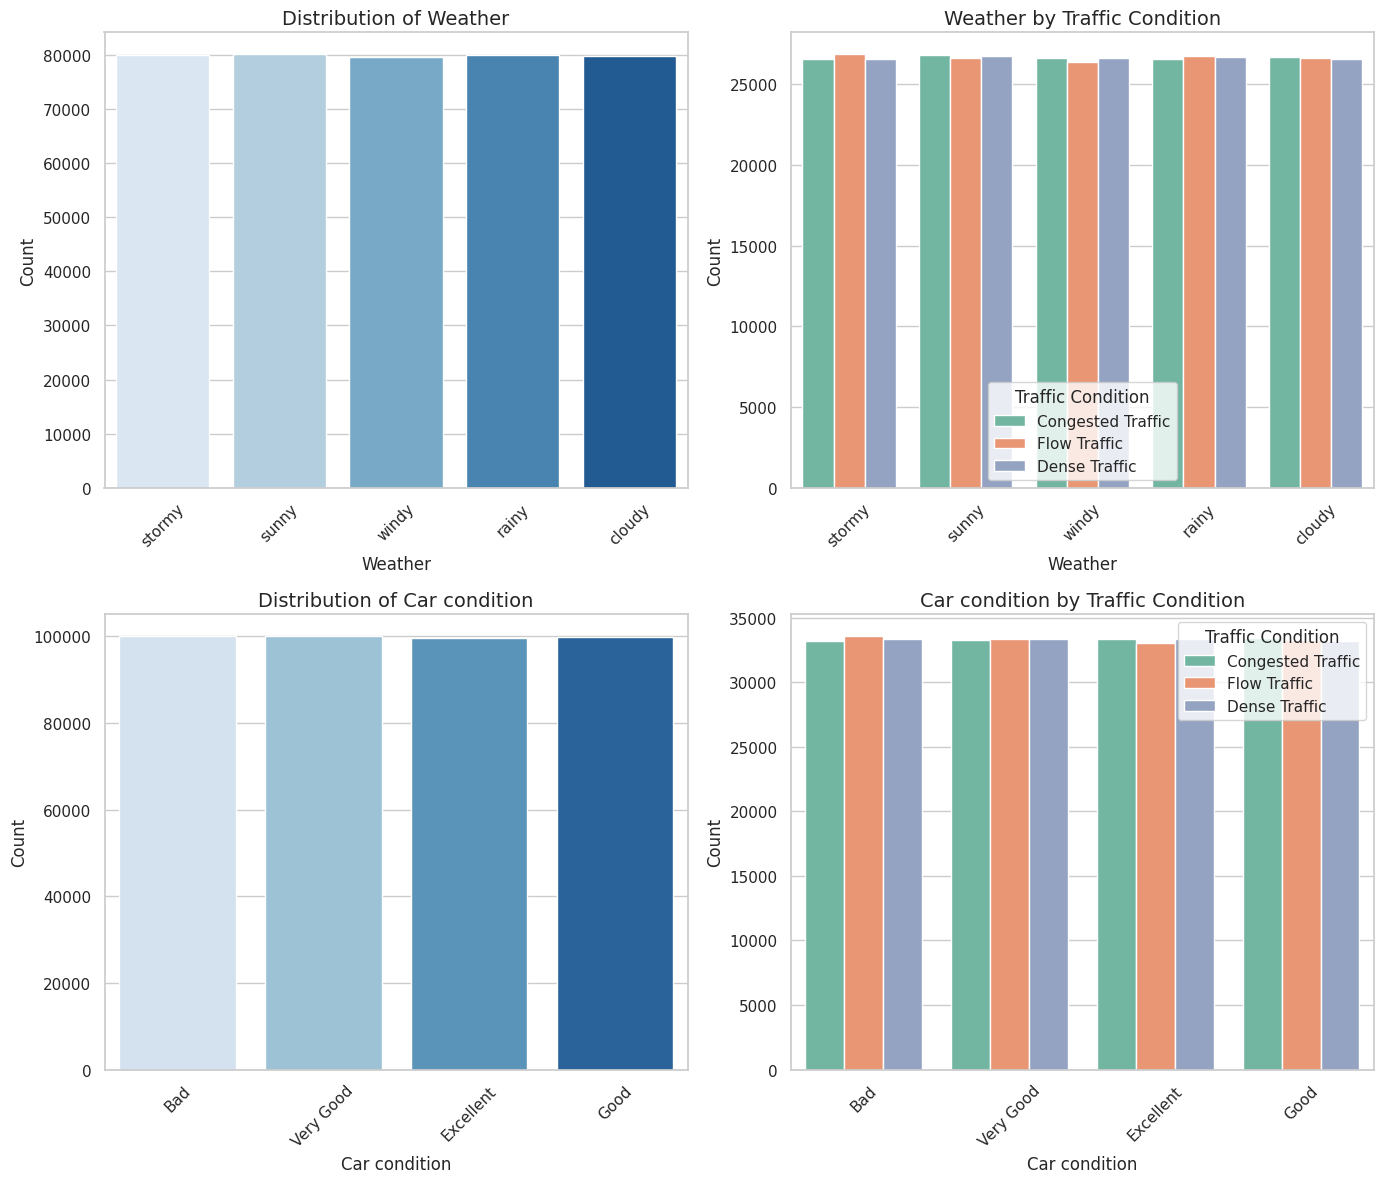

In [79]:
categorical_features = ['Weather', 'Car Condition']
# Create subplots: Each feature gets 2 plots (1 for distribution, 1 for relation with Traffic Condition)
fig, axes = plt.subplots(len(categorical_features), 2, figsize=(14, 6 * len(categorical_features)))
for i, feature in enumerate(categorical_features):
    # Plot value counts (Distribution)
    sns.countplot(x=feature, data=data, ax=axes[i, 0], palette='Blues')
    axes[i, 0].set_title(f'Distribution of {feature.capitalize()}', fontsize=14)
    axes[i, 0].set_xlabel(feature.capitalize(), fontsize=12)
    axes[i, 0].set_ylabel('Count', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=45)  # Rotate labels if needed
    # Plot relationship with Traffic Condition
    sns.countplot(x=feature, hue='Traffic Condition', data=data, ax=axes[i, 1], palette='Set2')
    axes[i, 1].set_title(f'{feature.capitalize()} by Traffic Condition', fontsize=14)
    axes[i, 1].set_xlabel(feature.capitalize(), fontsize=12)
    axes[i, 1].set_ylabel('Count', fontsize=12)
    axes[i, 1].tick_params(axis='x', rotation=45)  # Rotate labels if needed

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# 8. Numerical features

In [80]:
num_features = ['fare_amount', 'passenger_count']

print("Raw data sample:")
data[num_features].head()

Raw data sample:


fare_amount  passenger_count
2          5.7                2
3          7.7                1
4          5.3                1
5         12.1                1
6          7.5                1

In [81]:
print("Raw data stats:")
data[num_features].describe()

Raw data stats:


fare_amount  passenger_count
count  399683.000000    399683.000000
mean        8.460908         1.678340
std         3.636485         1.303592
min        -3.000000         0.000000
25%         5.700000         1.000000
50%         7.700000         1.000000
75%        10.500000         2.000000
max        22.100000         6.000000

We now shift our focus to the numerical features, starting with `fare_amount`, which represents the cost of each trip. Our initial exploration reveals several key characteristics about its distribution and behavior:

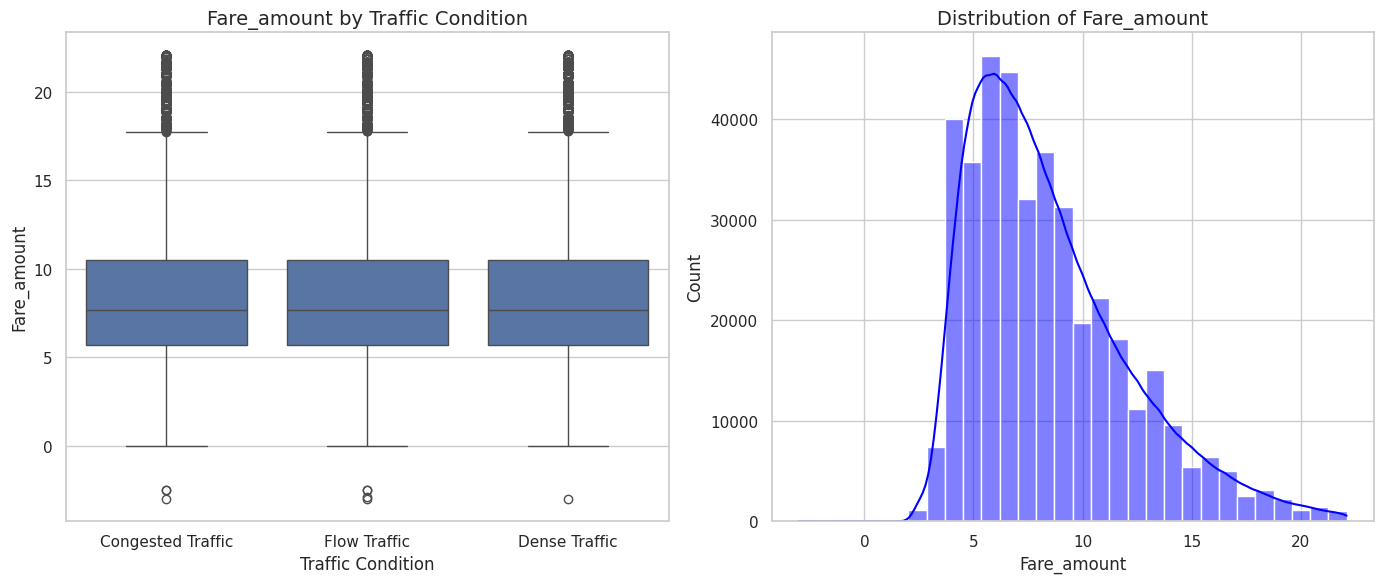

In [82]:
# Select the feature
feature = 'fare_amount'
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Boxplot (Left)
sns.boxplot(x='Traffic Condition', y=feature, data=data, ax=axes[0])
axes[0].set_title(f'{feature.capitalize()} by Traffic Condition', fontsize=14)
axes[0].set_xlabel('Traffic Condition', fontsize=12)
axes[0].set_ylabel(feature.capitalize(), fontsize=12)
# Histogram (Right)
sns.histplot(data[feature], ax=axes[1], kde=True, bins=30, color='blue')
axes[1].set_title(f'Distribution of {feature.capitalize()}', fontsize=14)
axes[1].set_xlabel(feature.capitalize(), fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
# Adjust layout for better spacing
plt.tight_layout()
# Show the plots
plt.show()

Next, we explore the `passenger_count` feature, which records the number of passengers per trip. The possible values observed are 0, 1, 2, 3, 4, 5, and 6, and their distribution provides the following insights:

- **Dominance of Single Passengers**: The value `1` has the highest frequency, with approximately 350,000 occurrences, making it the most common passenger count. This suggests that solo trips dominate the dataset, aligning with typical urban taxi usage patterns where individual travel is prevalent.
- **Presence of Zero Passengers**: A value of `0` exists but has the lowest count among all options. While less frequent, these zero-passenger trips are notable and could indicate data errors, cancelled rides, or trips logged without passengers (e.g., driver repositioning), warranting further scrutiny.
- **Higher Counts (2, 3, and 5)**: Values of `2`, `3`, and `5` passengers are present and occur with moderate frequency, though less than `1`. These counts reflect small groups or families using taxi services, which are common but not as dominant as solo trips. Their presence indicates a diversity of trip types within the dataset.
- **Lesser Counts (4 and 6)**: Values of `4` and `6` are observed but have lower frequencies compared to `2`, `3`, and `5`. These likely represent larger groups or near-capacity rides, which are less common due to the practical limits of standard taxi vehicles (typically seating 4-6 passengers) and the rarity of such group travel in urban settings.

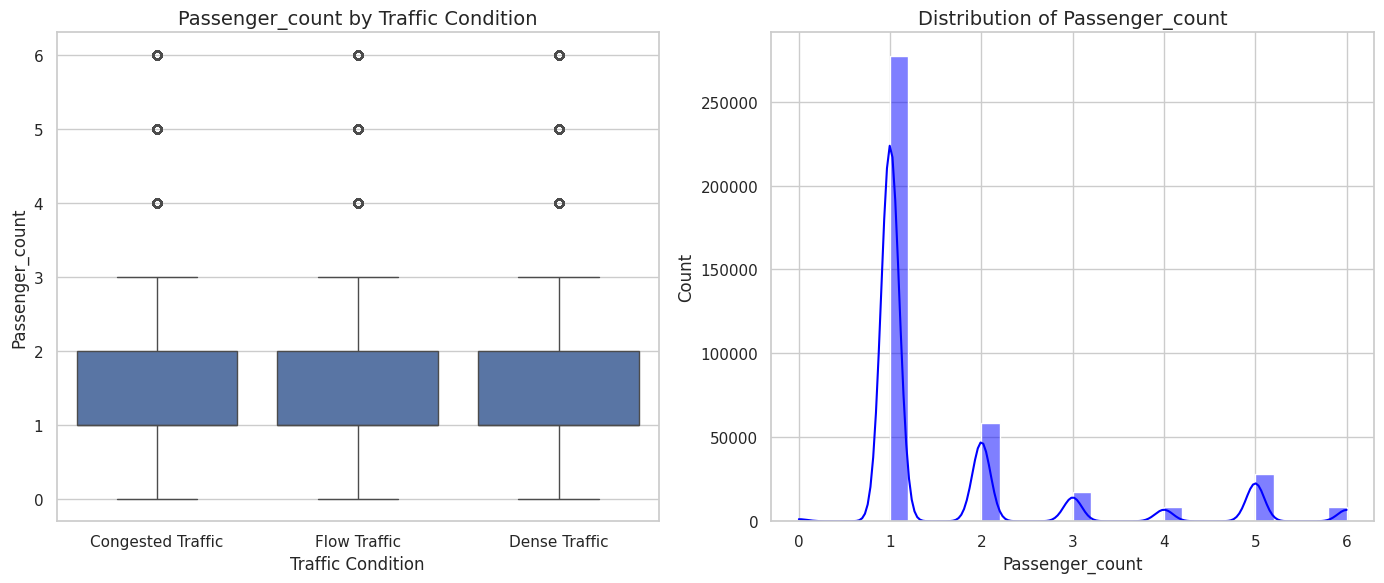

In [83]:
# Select the feature
feature = 'passenger_count'
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Boxplot (Left)
sns.boxplot(x='Traffic Condition', y=feature, data=data, ax=axes[0])
axes[0].set_title(f'{feature.capitalize()} by Traffic Condition', fontsize=14)
axes[0].set_xlabel('Traffic Condition', fontsize=12)
axes[0].set_ylabel(feature.capitalize(), fontsize=12)
# Histogram (Right)
sns.histplot(data[feature], ax=axes[1], kde=True, bins=30, color='blue')
axes[1].set_title(f'Distribution of {feature.capitalize()}', fontsize=14)
axes[1].set_xlabel(feature.capitalize(), fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
# Adjust layout for better spacing
plt.tight_layout()
# Show the plots
plt.show()

# 9. Time-related features

In [84]:
# Define time-related features
time_features = ['year', 'month', 'day', 'weekday', 'hour']

print("Raw data sample:")
data[time_features].head()

Raw data sample:


year  month  day  weekday  hour
2  2011      8   18        3     0
3  2012      4   21        5     4
4  2010      3    9        1     7
5  2011      1    6        3     9
6  2012     11   20        1    20

In [85]:
print("Raw data stats:")
data[time_features].describe()

Raw data stats:


year          month            day        weekday  \
count  399683.000000  399683.000000  399683.000000  399683.000000   
mean     2011.713668       6.252693      15.669100       3.017224   
std         1.861969       3.445810       8.678301       1.937763   
min      2009.000000       1.000000       1.000000       0.000000   
25%      2010.000000       3.000000       8.000000       1.000000   
50%      2012.000000       6.000000      16.000000       3.000000   
75%      2013.000000       9.000000      23.000000       5.000000   
max      2015.000000      12.000000      31.000000       6.000000   

                hour  
count  399683.000000  
mean       13.702589  
std         6.304699  
min         0.000000  
25%         9.000000  
50%        14.000000  
75%        19.000000  
max        23.000000

We now examine the time-related features—`year`, `month`, `day`, `weekday`, and `hour`—to uncover temporal patterns in trip activity. These features provide insights into how trip counts vary across different time scales. Below are the key observations for each:

- **Year**: The dataset spans from 2009 to 2015. The year `2012` has the highest trip count, approximately 80,000, suggesting a peak in activity. Years `2009`, `2010`, `2011`, `2013`, and `2014` follow closely, each with slightly fewer trips but still exceeding 70,000, indicating consistent activity across these years. In contrast, `2015` has the lowest count, around 35,000, possibly due to incomplete data for that year or a decline in recorded trips.
- **Month**: Months `3` (March) and `5` (May) lead with the highest trip counts, each exceeding 45,000, pointing to seasonal peaks, perhaps tied to weather or events. Months `1`, `2`, `4`, `6`, and `10` are slightly lower but still robust, with counts above 40,000. Months `7`, `9`, `11`, and `12` fall below 40,000, while `8` (August) records the lowest at approximately 35,000, potentially reflecting a seasonal dip (e.g., summer slowdown).
- **Day**: Days between `9` and `23` show the highest distribution of trip counts, indicating mid-month activity is consistently elevated. Day `31`, however, has the lowest count, around 10,000, likely due to fewer months having 31 days, reducing its overall representation in the dataset.
- **Weekday**: Weekdays `4` (Thursday) and `5` (Friday) have the highest trip counts, approximately 75,000 each, suggesting peak travel toward the weekend. Weekdays `6` (Saturday) and `0` (Sunday) are the lowest, around 65,000 each, reflecting a possible shift in travel patterns over the weekend, though still significant.
- **Hour**: The rush hours from `6 PM` to `10 PM` exhibit the highest trip counts, aligning with evening commuting or social activities. The period from `8 AM` to `5 PM` also shows significant counts, capturing daytime travel. The early morning hour of `5 AM` has the lowest count, approximately 5,000, while hours `1 AM` to `4 AM`, `6 AM`, and `7 AM` are also low, with counts under 15,000 each (assuming a typo in 'under 150,000' given the scale), indicating minimal activity during late-night and early-morning periods.

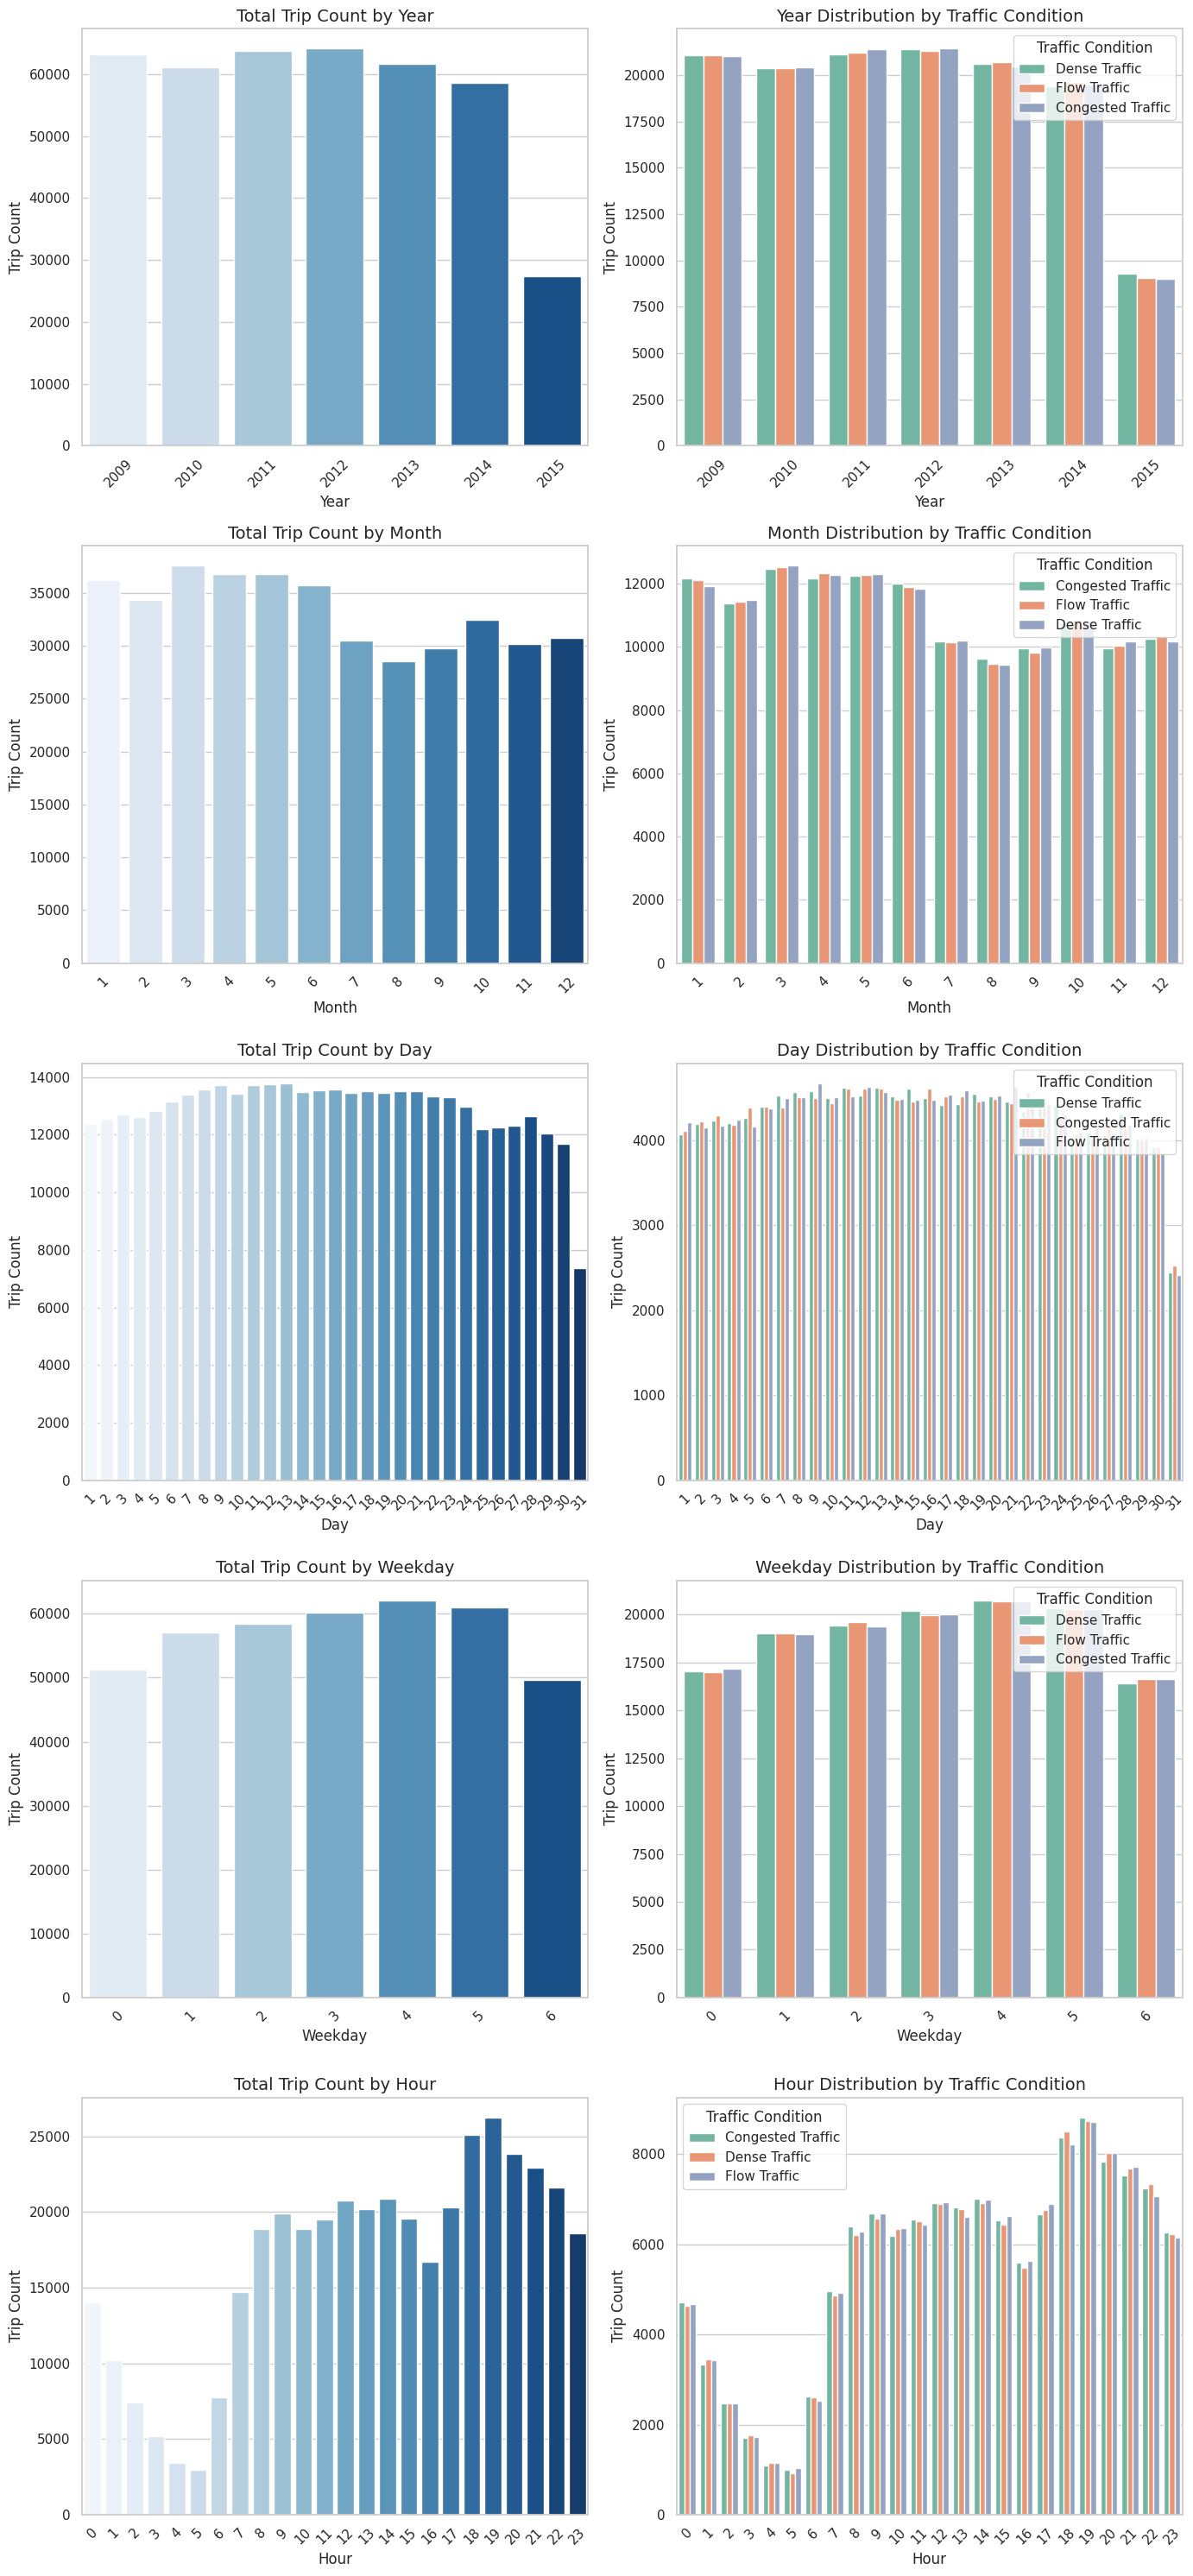

In [86]:
# Define time-related features
time_features = ['year', 'month', 'day', 'weekday', 'hour']
# Create subplots: 4 rows, 2 columns (one for each feature)
fig, axes = plt.subplots(len(time_features), 2, figsize=(14, 6 * len(time_features)))

for i, feature in enumerate(time_features):
    # --- (1) Plot total trip counts ---
    sns.countplot(x=feature, data=data, ax=axes[i, 0], palette='Blues')
    axes[i, 0].set_title(f'Total Trip Count by {feature.capitalize()}', fontsize=14)
    axes[i, 0].set_xlabel(feature.capitalize(), fontsize=12)
    axes[i, 0].set_ylabel('Trip Count', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=45)  # Rotate x labels if needed

    # --- (2) Plot trip counts split by Traffic Condition ---
    sns.countplot(x=feature, hue='Traffic Condition', data=data, ax=axes[i, 1], palette='Set2')
    axes[i, 1].set_title(f'{feature.capitalize()} Distribution by Traffic Condition', fontsize=14)
    axes[i, 1].set_xlabel(feature.capitalize(), fontsize=12)
    axes[i, 1].set_ylabel('Trip Count', fontsize=12)
    axes[i, 1].tick_params(axis='x', rotation=45)  # Rotate x labels if needed
    axes[i, 1].legend(title='Traffic Condition')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# 10. Distance-related features

In [87]:
# Define distance-related features
dist_features = [ 'distance', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']

print("Raw data sample:")
data[dist_features].head()

Raw data sample:


distance   jfk_dist   ewr_dist   lga_dist   sol_dist   nyc_dist
2  1.389525  43.597686  33.712082  19.865289  17.722624   9.847344
3  2.799270  42.642965  32.556289  21.063132  15.738963   7.703421
4  1.999157  43.329953  39.406828  15.219339  23.732406  15.600745
5  3.787239  42.335622  32.824930  20.648176  15.741133   7.649541
6  1.555807  42.563234  35.482608  18.113693  19.126670  10.993150

In [88]:
print("Raw data stats:")
data[dist_features].describe()

Raw data stats:


distance       jfk_dist       ewr_dist       lga_dist  \
count  399683.000000  399683.000000  399683.000000  399683.000000   
mean        2.237120      42.755236      34.439592      19.560618   
std         1.403377       1.538247       3.448855       3.132535   
min         0.000000      38.338230      25.054302      10.570026   
25%         1.174805      41.731819      31.817872      17.306932   
50%         1.888249      42.644031      34.145857      19.517307   
75%         3.003037      43.701505      36.979411      21.800045   
max         6.478586      47.102701      44.785623      28.561759   

            sol_dist       nyc_dist  
count  399683.000000  399683.000000  
mean       17.811547       9.871464  
std         4.334656       4.200820  
min         6.425110       0.080500  
25%        14.579863       6.577584  
50%        17.722965       9.726279  
75%        21.070386      13.034633  
max        30.589773      22.669392

We now turn to the distance-related features—`distance`, `jfk_dist`, `ewr_dist`, `lga_dist`, `sol_dist`, and `nyc_dist`—which capture spatial aspects of the trips. These include the total trip distance (`distance`) and distances from the trip’s starting point to key NYC landmarks: JFK Airport, Newark (EWR) Airport, LaGuardia (LGA) Airport, the Statue of Liberty (SoL), and a central NYC point. Below are the key observations:

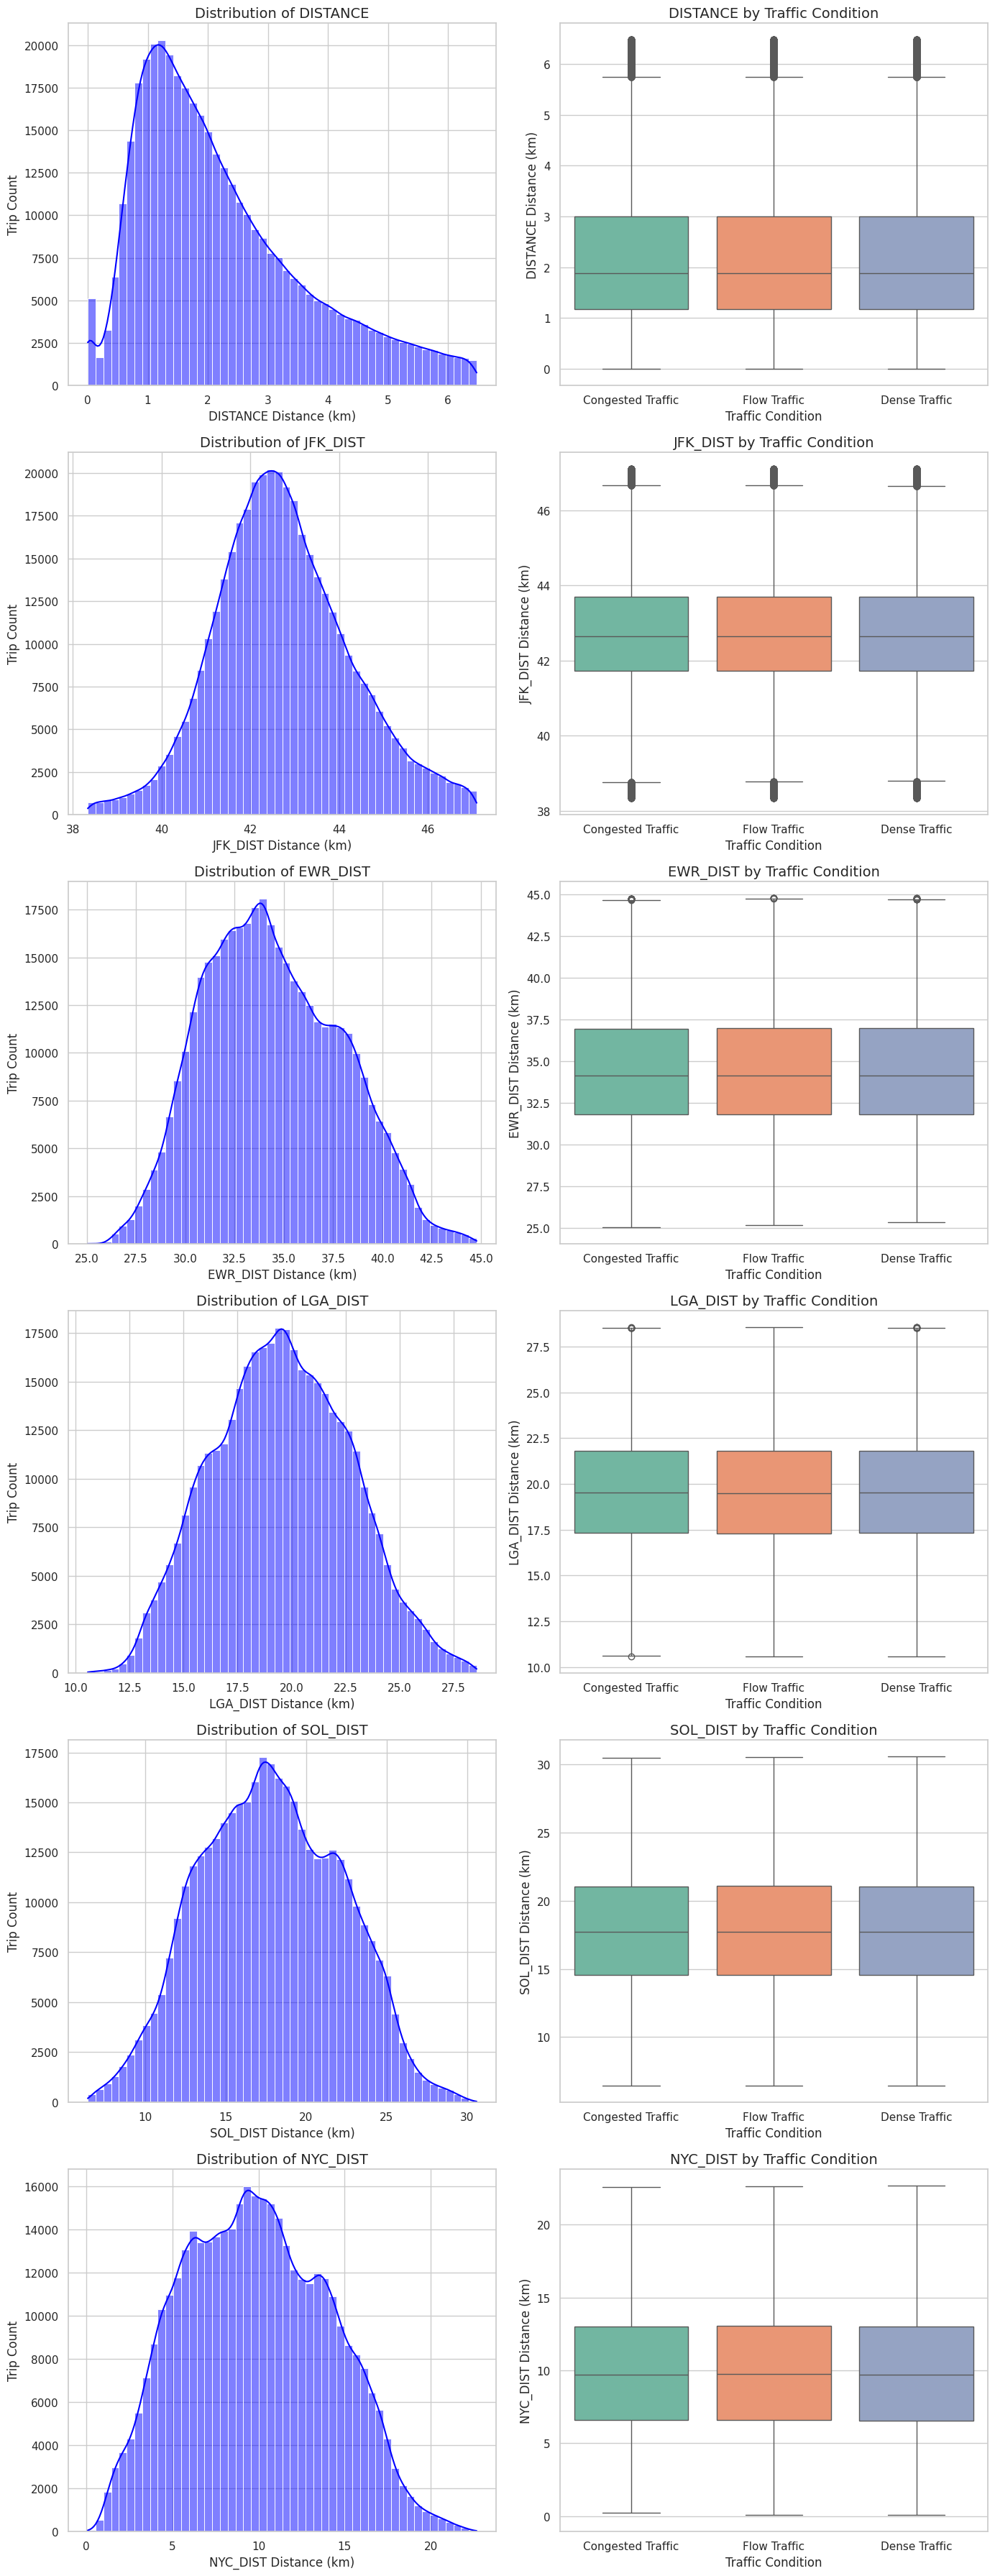

In [89]:
# Create subplots: Each feature gets 2 plots (1 for distribution, 1 for relation with Traffic Condition)
fig, axes = plt.subplots(len(dist_features), 2, figsize=(14, 6 * len(dist_features)))

for i, feature in enumerate(dist_features):
    # --- (1) Plot distribution of distance values ---
    sns.histplot(data[feature], bins=50, kde=True, ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'Distribution of {feature.upper()}', fontsize=14)
    axes[i, 0].set_xlabel(f'{feature.upper()} Distance (km)', fontsize=12)
    axes[i, 0].set_ylabel('Trip Count', fontsize=12)

    # --- (2) Plot distribution of trips per Traffic Condition ---
    sns.boxplot(x='Traffic Condition', y=feature, data=data, ax=axes[i, 1], palette='Set2')
    axes[i, 1].set_title(f'{feature.upper()} by Traffic Condition', fontsize=14)
    axes[i, 1].set_xlabel('Traffic Condition', fontsize=12)
    axes[i, 1].set_ylabel(f'{feature.upper()} Distance (km)', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# 11. Geografical-related features

In [90]:
# Define the features to process
coord_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

# Step 1: Initial inspection of raw data
print("Raw data sample:")
data[coord_cols].head()

Raw data sample:


pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude
2         0.711418         -1.291242          0.711231          -1.291391
3         0.710927         -1.291319          0.711363          -1.291396
4         0.711536         -1.290987          0.711811          -1.290787
5         0.710901         -1.291560          0.711365          -1.291071
6         0.711251         -1.291195          0.711481          -1.291086

In [91]:
print("Raw data stats:")
data[coord_cols].describe()

Raw data stats:


pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude
count    399683.000000     399683.000000     399683.000000      399683.000000
mean          0.711269         -1.291230          0.711275          -1.291218
std           0.000353          0.000277          0.000370           0.000291
min           0.709742         -1.292426          0.709723          -1.292438
25%           0.711029         -1.291418          0.711033          -1.291411
50%           0.711287         -1.291247          0.711298          -1.291236
75%           0.711503         -1.291055          0.711514          -1.291046
max           0.712622         -1.289814          0.712676          -1.289772

We now analyze the geographical features—`pickup_latitude`, `pickup_longitude`, `dropoff_latitude`, and `dropoff_longitude`—which define the starting and ending coordinates of each trip. Given the dataset’s context (e.g., distances to NYC landmarks like JFK and LGA), we expected these coordinates to cluster around New York City (latitude: 40.5 to 40.9, longitude: -74.3 to -73.7). However, our findings reveal significant contradictions:

- **Unexpected Locations**: The coordinates do not align with NYC as anticipated. Instead, they span diverse and distant regions, including central Brazil, off the coast of Africa, and the Atlantic Ocean. Examples from earlier checks (e.g., latitude -54.389440, longitude 0.000000) place points far from NYC, such as near Antarctica or the equator.
- **Valid but Misplaced**: All values fall within the technically valid ranges for latitude (-90 to 90) and longitude (-180 to 180), confirming they are geographically plausible coordinates. However, their distribution across global locations contradicts the dataset’s apparent NYC-centric framework, as suggested by features like `jfk_dist` and `nyc_dist`.
- **Implication of Discrepancy**: This mismatch suggests either a data collection error (e.g., incorrect coordinate assignment), a broader scope than assumed (e.g., global taxi data), or a misinterpretation of the dataset’s purpose. The presence of points in Brazil, Africa, and the Atlantic Ocean is inconsistent with urban taxi trips tied to NYC landmarks.

In [92]:
# Step 2: Check for out-of-range and missing values before cleaning
invalid_counts = {}
for col in coord_cols:
    if 'latitude' in col:
        invalid_counts[col] = data[~data[col].between(-90, 90)].shape[0]
    else:  # longitude
        invalid_counts[col] = data[~data[col].between(-180, 180)].shape[0]
print("Number of rows with out-of-range values:")
for col, count in invalid_counts.items():
    print(f"  {col}: {count}")

Number of rows with out-of-range values:
  pickup_latitude: 0
  pickup_longitude: 0
  dropoff_latitude: 0
  dropoff_longitude: 0


In [93]:
# Group by pickup coordinates and count trips
trip_counts = data.groupby(['pickup_latitude', 'pickup_longitude']).size().reset_index(name='count')

# Calculate mean coordinates for map centering
mean_lat = trip_counts['pickup_latitude'].mean()
mean_lon = trip_counts['pickup_longitude'].mean()
print(f"Map center: [{mean_lat}, {mean_lon}]")

Map center: [0.7112693455128564, -1.2912302940689717]


In [ ]:
# Create map
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=10)  # Zoom 10 for city view

# Add pickup points
for _, row in trip_counts.iterrows():
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=max(row['count'] / 10, 1),
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.4,
        popup=f"Trips: {row['count']}"
    ).add_to(m)

# Display map
m

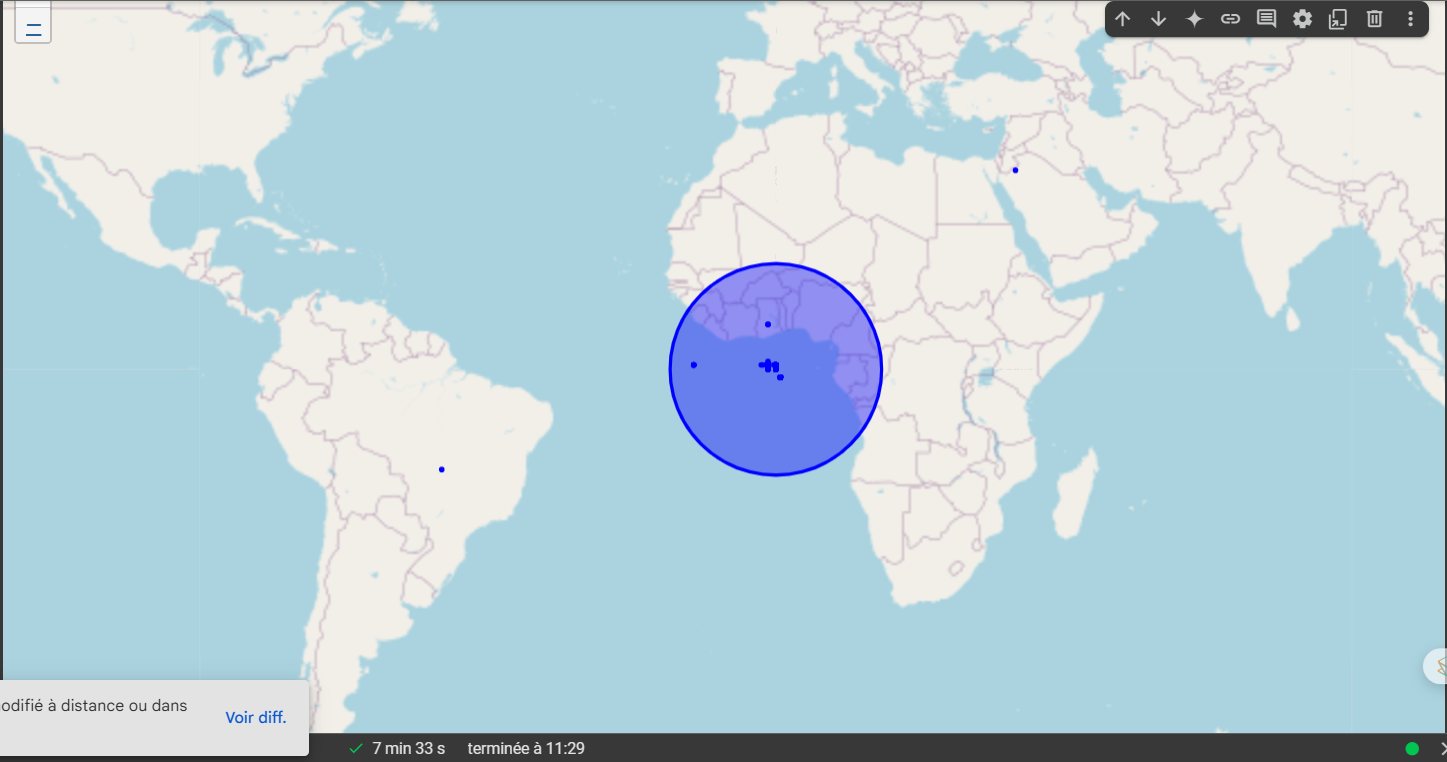

Having categorized and explored the dataset’s features, we now dive deeper into the relationships between key numerical variables—`fare_amount`, `passenger_count`, and the distance-related features (`distance`, `jfk_dist`, `ewr_dist`, `lga_dist`, `sol_dist`, `nyc_dist`). By examining these interactions, we aim to understand how distances influence trip costs, how passenger numbers relate to distances traveled, and how fares vary with passenger counts. This analysis will help reveal underlying patterns and potential dependencies, especially given the observed outliers and zero-value anomalies.

#### Case 1: How do different distances relate to fare amounts?
We start by investigating the relationship between `fare_amount` and the various distance features. Since `distance` represents the total trip length and the landmark distances (`jfk_dist`, `ewr_dist`, `lga_dist`, `sol_dist`, `nyc_dist`) measure proximity to key NYC points from the pickup location, we expect fares to increase with trip distance under normal circumstances.

In [94]:
# Define distance features and fare amount
dist_features = ['distance', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']
fare_col = 'fare_amount'

# Basic statistics for context
print("\nDescriptive Statistics for Fare Amount and Distances:")
display(data[[fare_col] + dist_features].describe())


Descriptive Statistics for Fare Amount and Distances:


fare_amount       distance       jfk_dist       ewr_dist  \
count  399683.000000  399683.000000  399683.000000  399683.000000   
mean        8.460908       2.237120      42.755236      34.439592   
std         3.636485       1.403377       1.538247       3.448855   
min        -3.000000       0.000000      38.338230      25.054302   
25%         5.700000       1.174805      41.731819      31.817872   
50%         7.700000       1.888249      42.644031      34.145857   
75%        10.500000       3.003037      43.701505      36.979411   
max        22.100000       6.478586      47.102701      44.785623   

            lga_dist       sol_dist       nyc_dist  
count  399683.000000  399683.000000  399683.000000  
mean       19.560618      17.811547       9.871464  
std         3.132535       4.334656       4.200820  
min        10.570026       6.425110       0.080500  
25%        17.306932      14.579863       6.577584  
50%        19.517307      17.722965       9.726279  
75%        21.800045      21.070386      13.034633  
max        28.561759      30.589773      22.669392

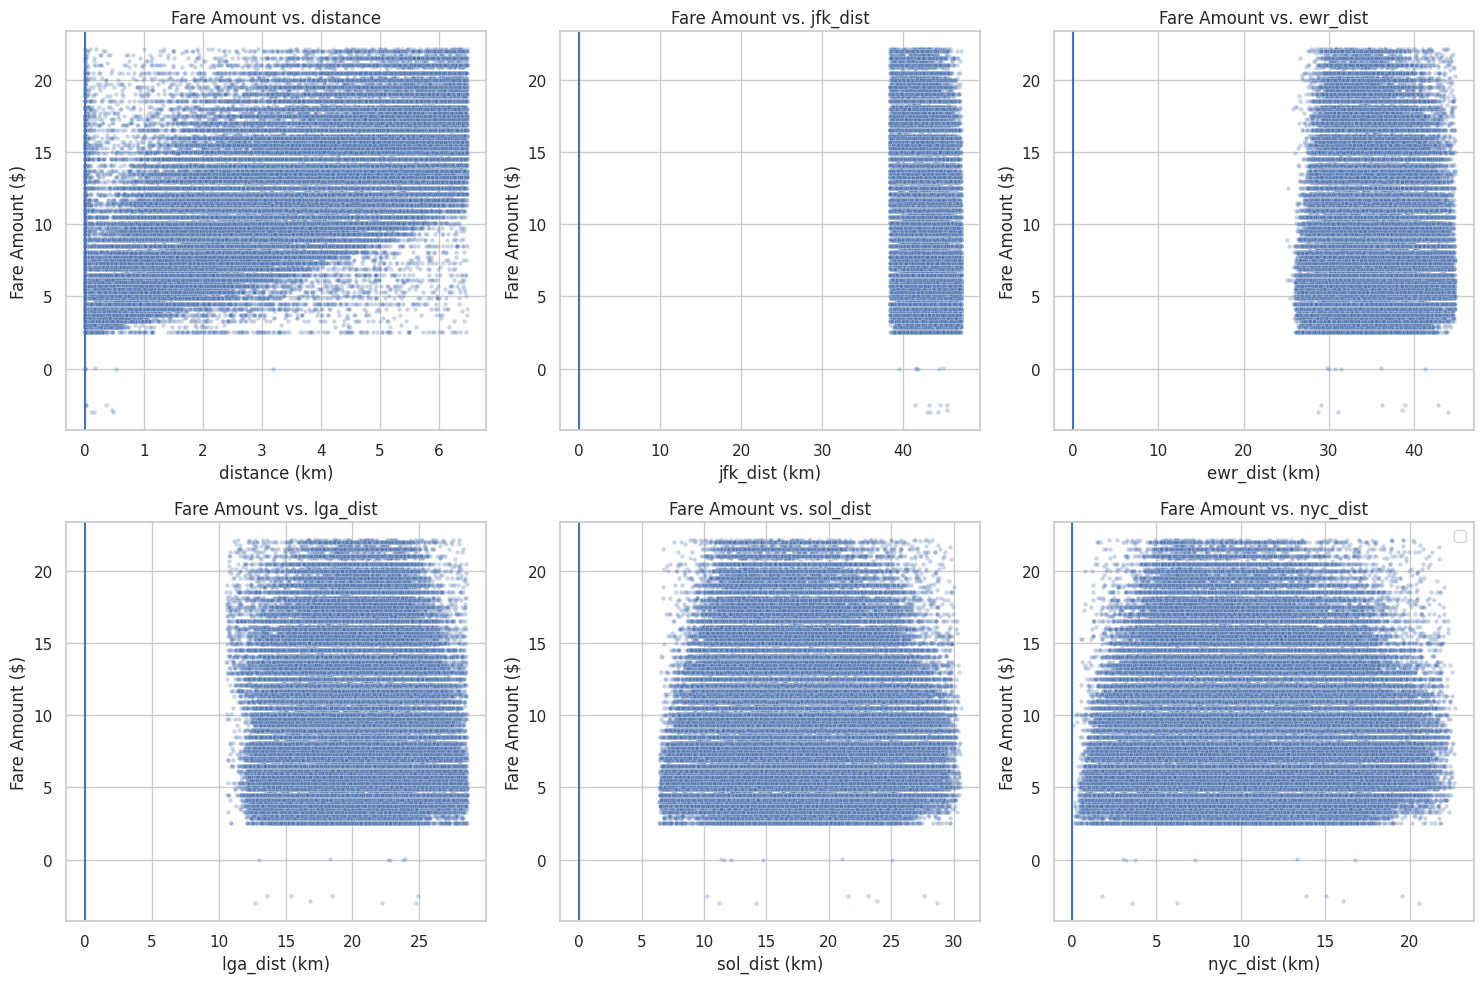

In [101]:
# Set up plot style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Create subplots for each distance feature
for i, dist in enumerate(dist_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=dist, y=fare_col, data=data, alpha=0.3, s=10)
    plt.title(f'Fare Amount vs. {dist}')
    plt.xlabel(f'{dist} (km)')
    plt.ylabel('Fare Amount ($)')
    plt.axvline()  # Reasonable max for urban trips

# Adjust layout and display
plt.tight_layout()
plt.legend()
plt.show()


Correlation between Fare Amount and Distances (Spearman):


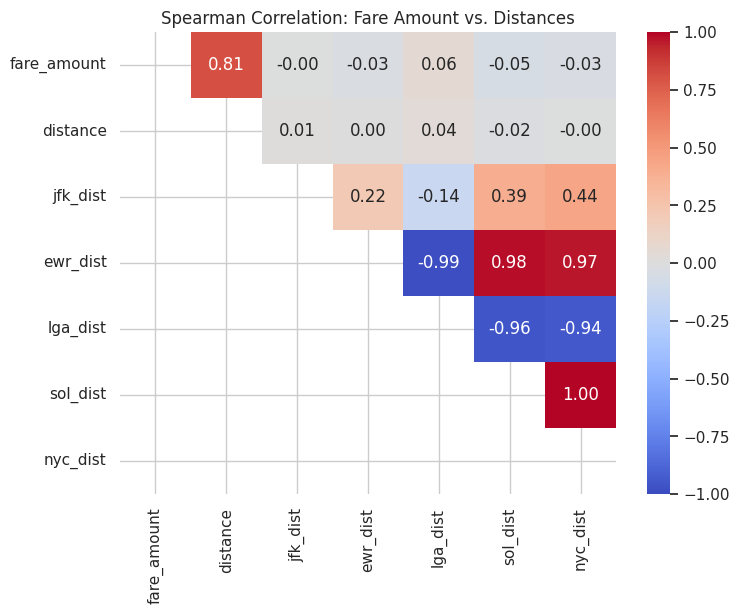

In [47]:
# Correlation analysis with heatmap
print("\nCorrelation between Fare Amount and Distances (Spearman):")
correlations = data[[fare_col] + dist_features].corr(method='spearman')  # Spearman for non-linear relationships
plt.figure(figsize=(8, 6))
mask = np.tril(np.ones_like(correlations, dtype=bool))
sns.heatmap(correlations, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Spearman Correlation: Fare Amount vs. Distances')
plt.show()

In [48]:
# Additional insight on zero values
zero_fares = data[data[fare_col] == 0].shape[0]
print(f"\nNumber of trips with zero fare: {zero_fares}")
for dist in dist_features:
    zero_dist = data[data[dist] == 0].shape[0]
    print(f"Number of trips with zero {dist}: {zero_dist}")


Number of trips with zero fare: 4
Number of trips with zero distance: 3149
Number of trips with zero jfk_dist: 0
Number of trips with zero ewr_dist: 0
Number of trips with zero lga_dist: 0
Number of trips with zero sol_dist: 0
Number of trips with zero nyc_dist: 0


#### Case 2: How do different distances relate to passenger counts?
Next, we explore how `passenger_count` varies with the distance features. Intuitively, longer trips (`distance`) might involve more passengers (e.g., group travel to airports), while proximity to landmarks (e.g., `jfk_dist`, `lga_dist`) could indicate specific trip purposes affecting passenger numbers. Given `passenger_count` peaks at 1 and includes rare higher values (5, 6), we aim to determine if distance influences group sizes or if zero-passenger trips align with zero distances, shedding light on data validity.

In [49]:
# Define distance features and passenger count
dist_features = ['distance', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']
passenger_col = 'passenger_count'

# Basic statistics for context
print("\nDescriptive Statistics for Passenger Count and Distances:")
display(data[[passenger_col] + dist_features].describe())


Descriptive Statistics for Passenger Count and Distances:


passenger_count       distance       jfk_dist       ewr_dist  \
count    399683.000000  399683.000000  399683.000000  399683.000000   
mean          1.678340       2.237120      42.755236      34.439592   
std           1.303592       1.403377       1.538247       3.448855   
min           0.000000       0.000000      38.338230      25.054302   
25%           1.000000       1.174805      41.731819      31.817872   
50%           1.000000       1.888249      42.644031      34.145857   
75%           2.000000       3.003037      43.701505      36.979411   
max           6.000000       6.478586      47.102701      44.785623   

            lga_dist       sol_dist       nyc_dist  
count  399683.000000  399683.000000  399683.000000  
mean       19.560618      17.811547       9.871464  
std         3.132535       4.334656       4.200820  
min        10.570026       6.425110       0.080500  
25%        17.306932      14.579863       6.577584  
50%        19.517307      17.722965       9.726279  
75%        21.800045      21.070386      13.034633  
max        28.561759      30.589773      22.669392

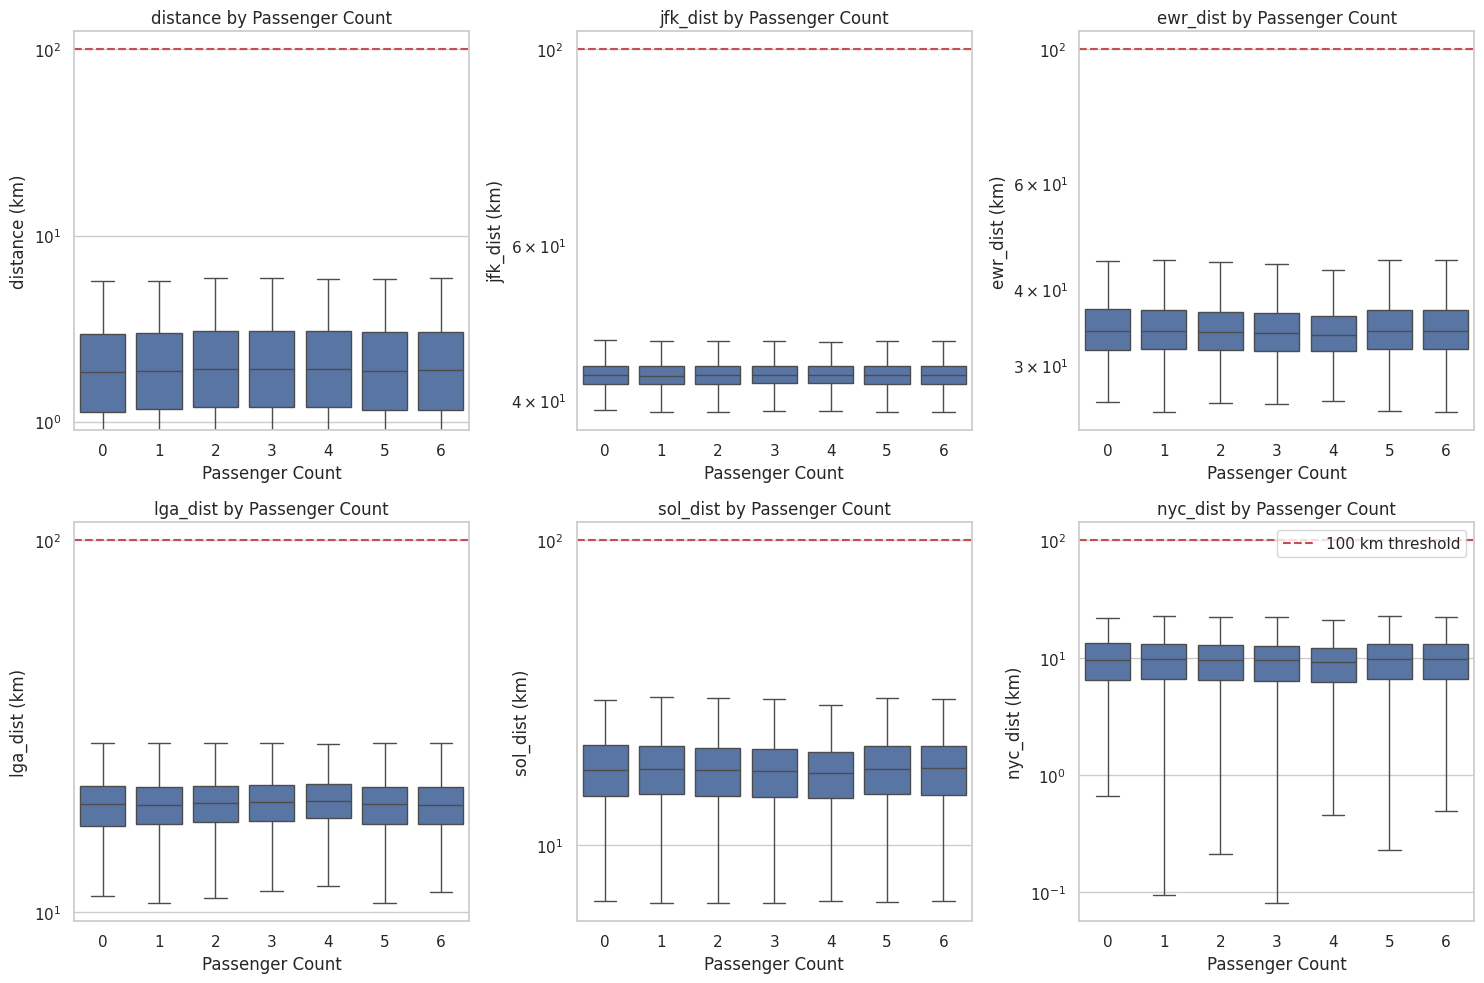

In [50]:
# Set up plot style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Create subplots for each distance feature
for i, dist in enumerate(dist_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=passenger_col, y=dist, data=data, showfliers=False)  # Exclude outliers for clarity
    plt.title(f'{dist} by Passenger Count')
    plt.xlabel('Passenger Count')
    plt.ylabel(f'{dist} (km)')
    plt.yscale('log')  # Log scale for distance due to extreme outliers (e.g., 12,000 km)
    plt.axhline(y=100, color='r', linestyle='--', label='100 km threshold')  # Reasonable max for urban trips

# Adjust layout and display
plt.tight_layout()
plt.legend()
plt.show()


Correlation between Passenger Count and Distances (Spearman):


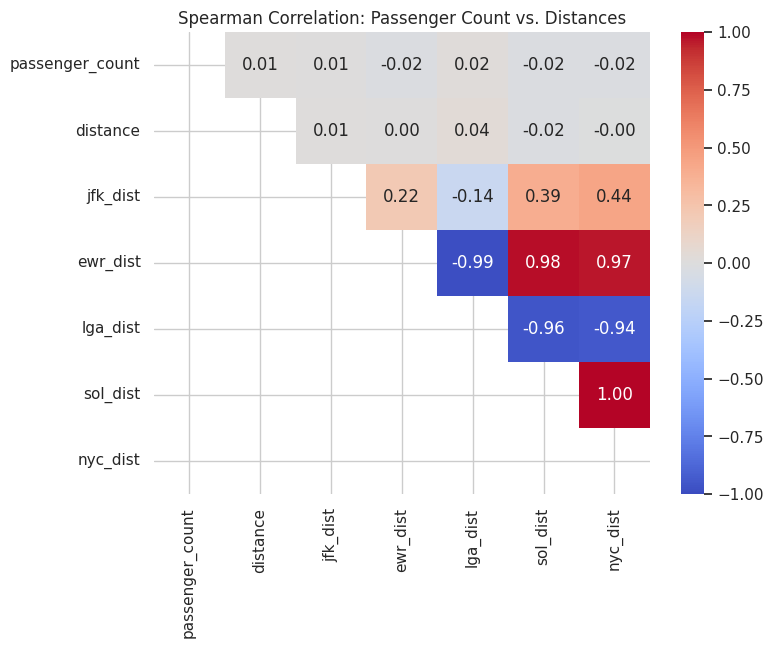

In [51]:
# Correlation analysis with heatmap
print("\nCorrelation between Passenger Count and Distances (Spearman):")
correlations = data[[passenger_col] + dist_features].corr(method='spearman')  # Spearman for non-linear relationships
plt.figure(figsize=(8, 6))
mask = np.tril(np.ones_like(correlations, dtype=bool))
sns.heatmap(correlations, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Spearman Correlation: Passenger Count vs. Distances')
plt.show()

In [52]:
# Median distances by passenger count
print("\nMedian Distances by Passenger Count:")
medians = data.groupby(passenger_col)[dist_features].median()
display(medians)

# Additional insight on zero values
zero_passengers = data[data[passenger_col] == 0].shape[0]
print(f"\nNumber of trips with zero passengers: {zero_passengers}")
for dist in dist_features:
    zero_dist = data[data[dist] == 0].shape[0]
    print(f"Number of trips with zero {dist}: {zero_dist}")


Median Distances by Passenger Count:


distance   jfk_dist   ewr_dist   lga_dist   sol_dist  \
passenger_count                                                         
0                1.837198  42.652579  34.177443  19.516965  17.648907   
1                1.879430  42.633464  34.203876  19.458590  17.786390   
2                1.924322  42.662226  33.997230  19.659495  17.558744   
3                1.924037  42.700054  33.854525  19.795282  17.446048   
4                1.927122  42.671025  33.680088  19.955442  17.213325   
5                1.879073  42.660880  34.183503  19.501305  17.763392   
6                1.888101  42.656156  34.203302  19.463180  17.820734   

                 nyc_dist  
passenger_count            
0                9.624706  
1                9.787873  
2                9.570362  
3                9.489441  
4                9.248808  
5                9.769515  
6                9.807542


Number of trips with zero passengers: 1511
Number of trips with zero distance: 3149
Number of trips with zero jfk_dist: 0
Number of trips with zero ewr_dist: 0
Number of trips with zero lga_dist: 0
Number of trips with zero sol_dist: 0
Number of trips with zero nyc_dist: 0


#### Case 3: How does passenger count relate to fare amount?
Finally, we analyze the relationship between `passenger_count` and `fare_amount`. One might hypothesize that higher passenger counts could lead to higher fares due to shared costs or special rates, but taxi pricing typically depends more on distance and time. With zero fares and a skewed passenger distribution, we’ll investigate whether fares scale with passengers or if anomalies (e.g., zero fares with zero passengers) dominate the relationship, potentially masking typical patterns.

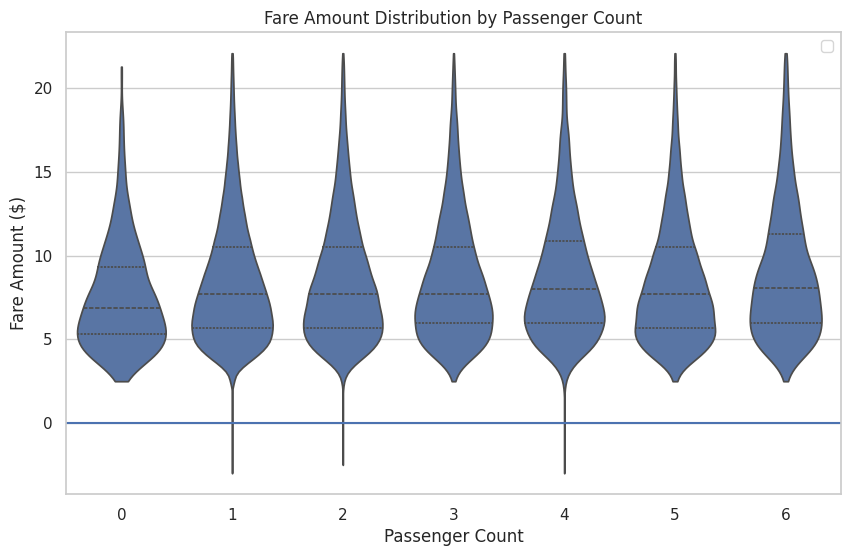

In [102]:
# Define columns
passenger_col = 'passenger_count'
fare_col = 'fare_amount'

# Set up plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Violin plot for fare_amount by passenger_count
sns.violinplot(x=passenger_col, y=fare_col, data=data, inner='quartile', cut=0)
plt.title('Fare Amount Distribution by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount ($)')
plt.axhline()  # Reasonable max for urban fares
plt.legend()
plt.show()


Correlation between Passenger Count and Fare Amount (Spearman):


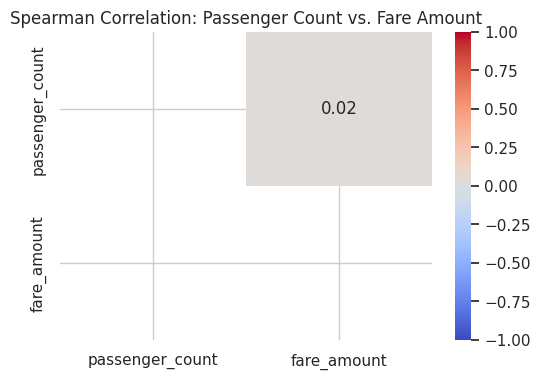

In [54]:
# Correlation analysis with heatmap
print("\nCorrelation between Passenger Count and Fare Amount (Spearman):")
correlations = data[[passenger_col, fare_col]].corr(method='spearman')  # Spearman for non-linear relationships
plt.figure(figsize=(6, 4))
mask = np.tril(np.ones_like(correlations, dtype=bool))
sns.heatmap(correlations, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Spearman Correlation: Passenger Count vs. Fare Amount')
plt.show()

In [55]:
# Median fare by passenger count
print("\nMedian Fare Amount by Passenger Count:")
medians = data.groupby(passenger_col)[fare_col].median()
display(medians)

# Additional insight on zero values
zero_passengers = data[data[passenger_col] == 0].shape[0]
zero_fares = data[data[fare_col] == 0].shape[0]
zero_both = data[(data[passenger_col] == 0) & (data[fare_col] == 0)].shape[0]
print(f"\nNumber of trips with zero passengers: {zero_passengers}")
print(f"Number of trips with zero fare: {zero_fares}")
print(f"Number of trips with both zero passengers and zero fare: {zero_both}")


Median Fare Amount by Passenger Count:


passenger_count
0    6.9
1    7.7
2    7.7
3    7.7
4    8.0
5    7.7
6    8.1
Name: fare_amount, dtype: float64


Number of trips with zero passengers: 1511
Number of trips with zero fare: 4
Number of trips with both zero passengers and zero fare: 0


#### Case 4: How do time features relate to total trip distance?

We explore whether specific months, days, or hours correlate with longer trip distances, potentially indicating seasonal or daily travel patterns. The `distance` feature, representing total trip length, while time features revealed peaks (e.g., March and May with over 45,000 trips, 6-10 PM rush hours). We hypothesize that longer trips might occur during certain months (e.g., holiday travel in December), days (e.g., mid-month activity from days 9-23), or hours (e.g., airport runs during evening rush). This analysis will assess if temporal factors drive trip length, despite the prevalence of zero distances, and help identify actionable patterns for further investigation.

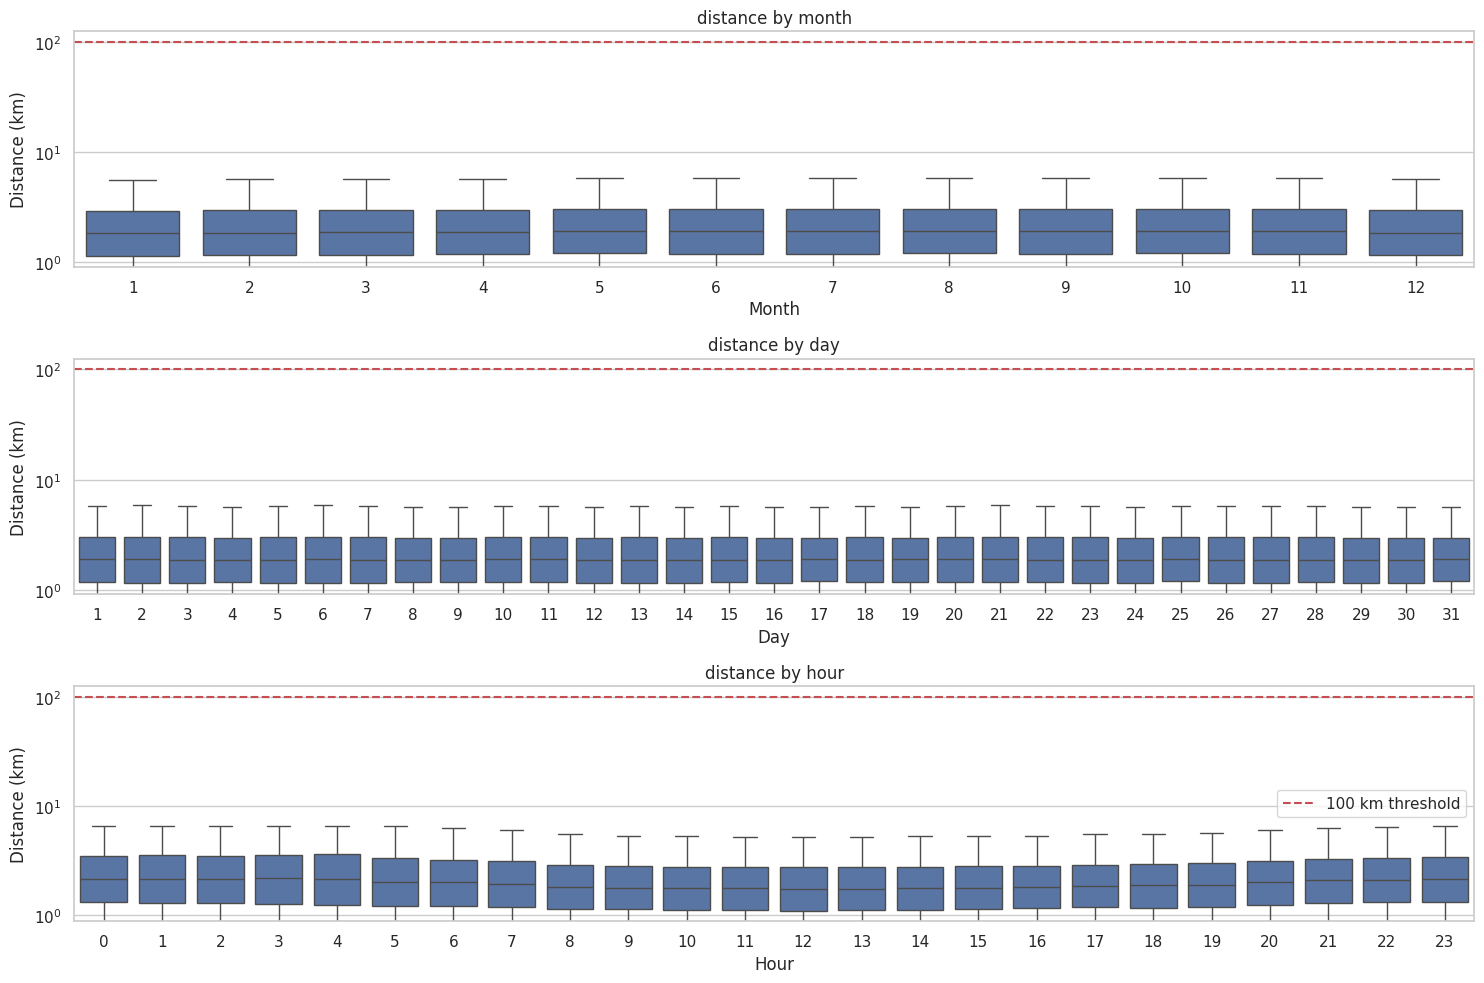

In [56]:
# Define features
time_features = ['month', 'day', 'hour']  # Subset for focus; add 'year', 'weekday' if desired
dist_col = 'distance'

# Plot setup
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Box plots for each time feature vs. distance
for i, time_feat in enumerate(time_features, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=time_feat, y=dist_col, data=data, showfliers=False)
    plt.title(f'{dist_col} by {time_feat}')
    plt.xlabel(time_feat.capitalize())
    plt.ylabel('Distance (km)')
    plt.yscale('log')  # Log scale for outliers
    plt.axhline(y=100, color='r', linestyle='--', label='100 km threshold')

plt.tight_layout()
plt.legend()
plt.show()


Correlation between Time Features and Distance (Spearman):


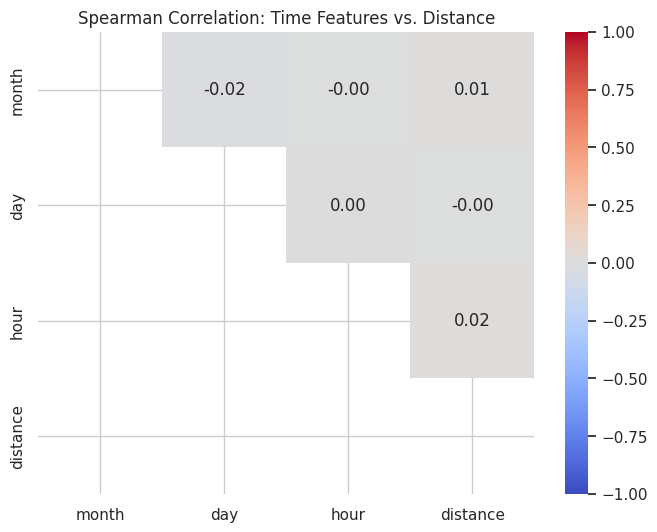

In [57]:
# Correlation matrix with heatmap
print("\nCorrelation between Time Features and Distance (Spearman):")
correlations = data[time_features + [dist_col]].corr(method='spearman')
plt.figure(figsize=(8, 6))
mask = np.tril(np.ones_like(correlations, dtype=bool))
sns.heatmap(correlations, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Spearman Correlation: Time Features vs. Distance')
plt.show()

In [58]:
# Median distances by time feature
for time_feat in time_features:
    print(f"\nMedian Distance by {time_feat}:")
    medians = data.groupby(time_feat)[dist_col].median()
    display(medians)

# Zero distance insight
zero_dist = data[data[dist_col] == 0].shape[0]
print(f"\nNumber of trips with zero distance: {zero_dist}")


Median Distance by month:


month
1     1.828976
2     1.846550
3     1.865181
4     1.886079
5     1.914175
6     1.914524
7     1.919981
8     1.920368
9     1.910123
10    1.913585
11    1.902908
12    1.852970
Name: distance, dtype: float64


Median Distance by day:


day
1     1.895337
2     1.911270
3     1.866997
4     1.889840
5     1.870722
6     1.898963
7     1.892257
8     1.885686
9     1.879400
10    1.897527
11    1.896196
12    1.874678
13    1.890514
14    1.889339
15    1.887961
16    1.880237
17    1.894846
18    1.884866
19    1.900427
20    1.902325
21    1.915605
22    1.883664
23    1.884998
24    1.865429
25    1.899894
26    1.888881
27    1.867142
28    1.893079
29    1.877309
30    1.875749
31    1.923991
Name: distance, dtype: float64


Median Distance by hour:


hour
0     2.144048
1     2.141735
2     2.146158
3     2.169283
4     2.145509
5     1.976546
6     1.981238
7     1.922167
8     1.808521
9     1.751979
10    1.758010
11    1.748479
12    1.724776
13    1.735557
14    1.742631
15    1.773546
16    1.799016
17    1.847676
18    1.862037
19    1.886722
20    1.987496
21    2.061776
22    2.100220
23    2.145586
Name: distance, dtype: float64


Number of trips with zero distance: 3149


#### Case 5: How do time features relate to landmark distances?

Are there specific months, days, or hours when passengers are closer to or farther from landmarks like JFK, LGA, or the Statue of Liberty? The landmark distance features (`jfk_dist`, `ewr_dist`, `lga_dist`, `sol_dist`, `nyc_dist`) exhibited an overwhelming zero values, suggesting either data artifacts or pickups at these exact locations. Time features showed distinct patterns (e.g., March/May peaks >45,000 trips, Thursday/Friday highs ~75,000). This case tests whether temporal trends align with proximity to NYC landmarks—such as airport travel during holidays (e.g., December) or tourist visits in summer (e.g., July for `sol_dist`)—despite the global coordinate spread complicating the NYC context.

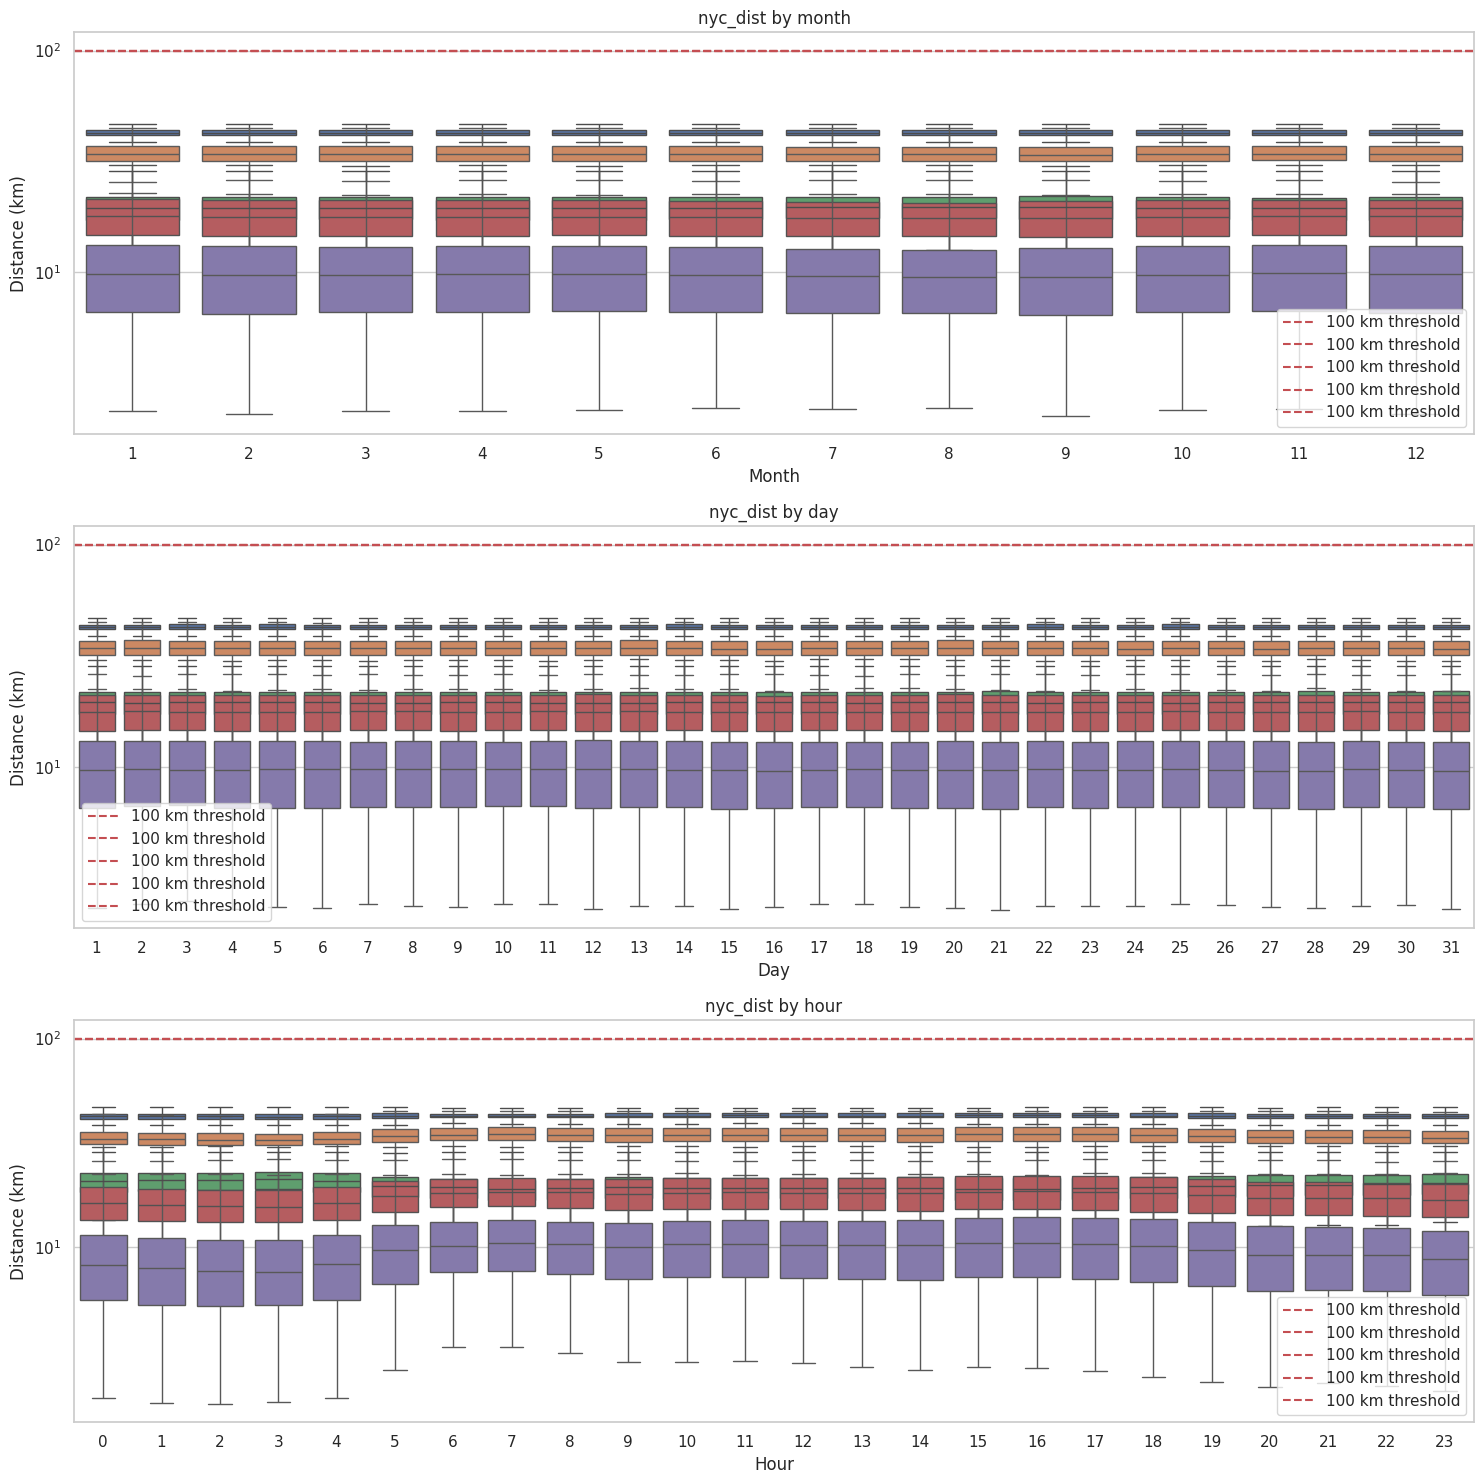

In [59]:
# Define features
time_features = ['month', 'day', 'hour']
landmark_dists = ['jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']

# Plot setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Box plots for month vs. each landmark distance (example with month; repeat for day, hour if desired)
for i, time_feat in enumerate(time_features):
    for dist in landmark_dists:
        sns.boxplot(x=time_feat, y=dist, data=data, showfliers=False, ax=axes[i])
        axes[i].set_title(f'{dist} by {time_feat}')
        axes[i].set_xlabel(time_feat.capitalize())
        axes[i].set_ylabel('Distance (km)')
        axes[i].set_yscale('log')
        axes[i].axhline(y=100, color='r', linestyle='--', label='100 km threshold')
    axes[i].legend()

plt.tight_layout()
plt.show()


Correlation between Time Features and Landmark Distances (Spearman):


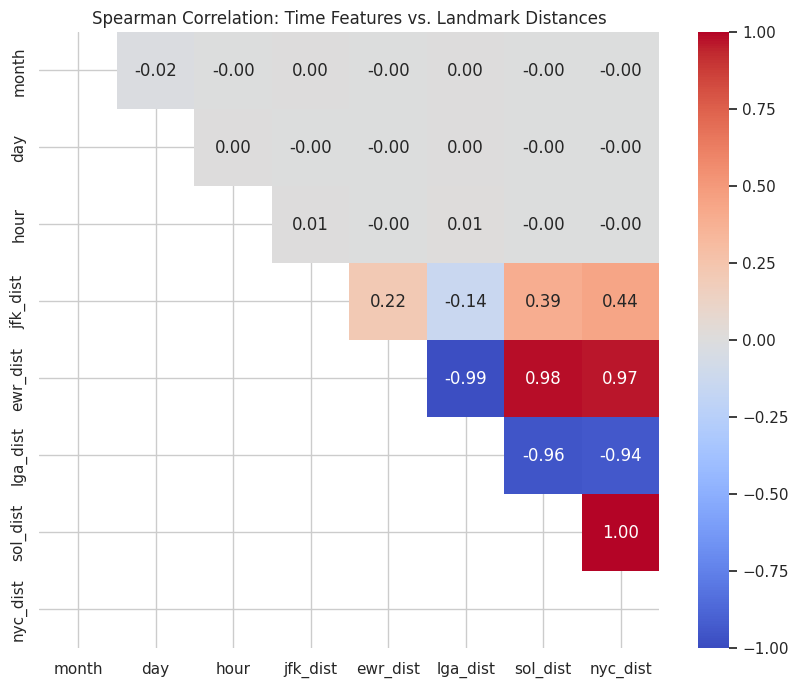

In [60]:
# Correlation matrix with heatmap
print("\nCorrelation between Time Features and Landmark Distances (Spearman):")
correlations = data[time_features + landmark_dists].corr(method='spearman')
plt.figure(figsize=(10, 8))
mask = np.tril(np.ones_like(correlations, dtype=bool))
sns.heatmap(correlations, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Spearman Correlation: Time Features vs. Landmark Distances')
plt.show()

In [61]:
# Median landmark distances by month (example; repeat for day, hour)
print("\nMedian Landmark Distances by Month:")
medians = data.groupby('month')[landmark_dists].median()
display(medians)

# Zero distance insight
for dist in landmark_dists:
    zero_dist = data[data[dist] == 0].shape[0]
    print(f"Number of trips with zero {dist}: {zero_dist}")


Median Landmark Distances by Month:


jfk_dist   ewr_dist   lga_dist   sol_dist  nyc_dist
month                                                      
1      42.614810  34.256840  19.417126  17.858192  9.850591
2      42.634973  34.158064  19.509668  17.734779  9.729771
3      42.635657  34.149596  19.516966  17.735722  9.735963
4      42.652382  34.200565  19.467081  17.784048  9.793882
5      42.668277  34.186164  19.480826  17.778272  9.791601
6      42.655410  34.135515  19.534932  17.721605  9.724955
7      42.627703  34.019020  19.624864  17.580919  9.589064
8      42.617834  33.983867  19.661675  17.531631  9.538251
9      42.663445  33.957166  19.692517  17.478900  9.471163
10     42.652755  34.166739  19.492470  17.724789  9.725725
11     42.664264  34.245632  19.434408  17.852912  9.859751
12     42.638212  34.261617  19.408849  17.853010  9.844845

Number of trips with zero jfk_dist: 0
Number of trips with zero ewr_dist: 0
Number of trips with zero lga_dist: 0
Number of trips with zero sol_dist: 0
Number of trips with zero nyc_dist: 0


#### Case 6: How do weekday and hour combinations affect distance patterns?

Do specific weekday-hour combinations correlate with longer trip distances or closer landmark proximity? Our earlier analysis highlighted `weekday` peaks on Thursday and Friday (~75,000 trips) and `hour` peaks from 6-10 PM, suggesting busy travel periods. Combining these dimensions could reveal nuanced patterns—such as longer trips on Friday evenings (e.g., airport runs) or closer proximity to the Statue of Liberty on Saturday afternoons (tourist visits). This case examines how these time combinations influence `distance` and landmark distances, aiming to pinpoint peak travel behaviors amidst the dataset’s zero-value dominance and global coordinate outliers.

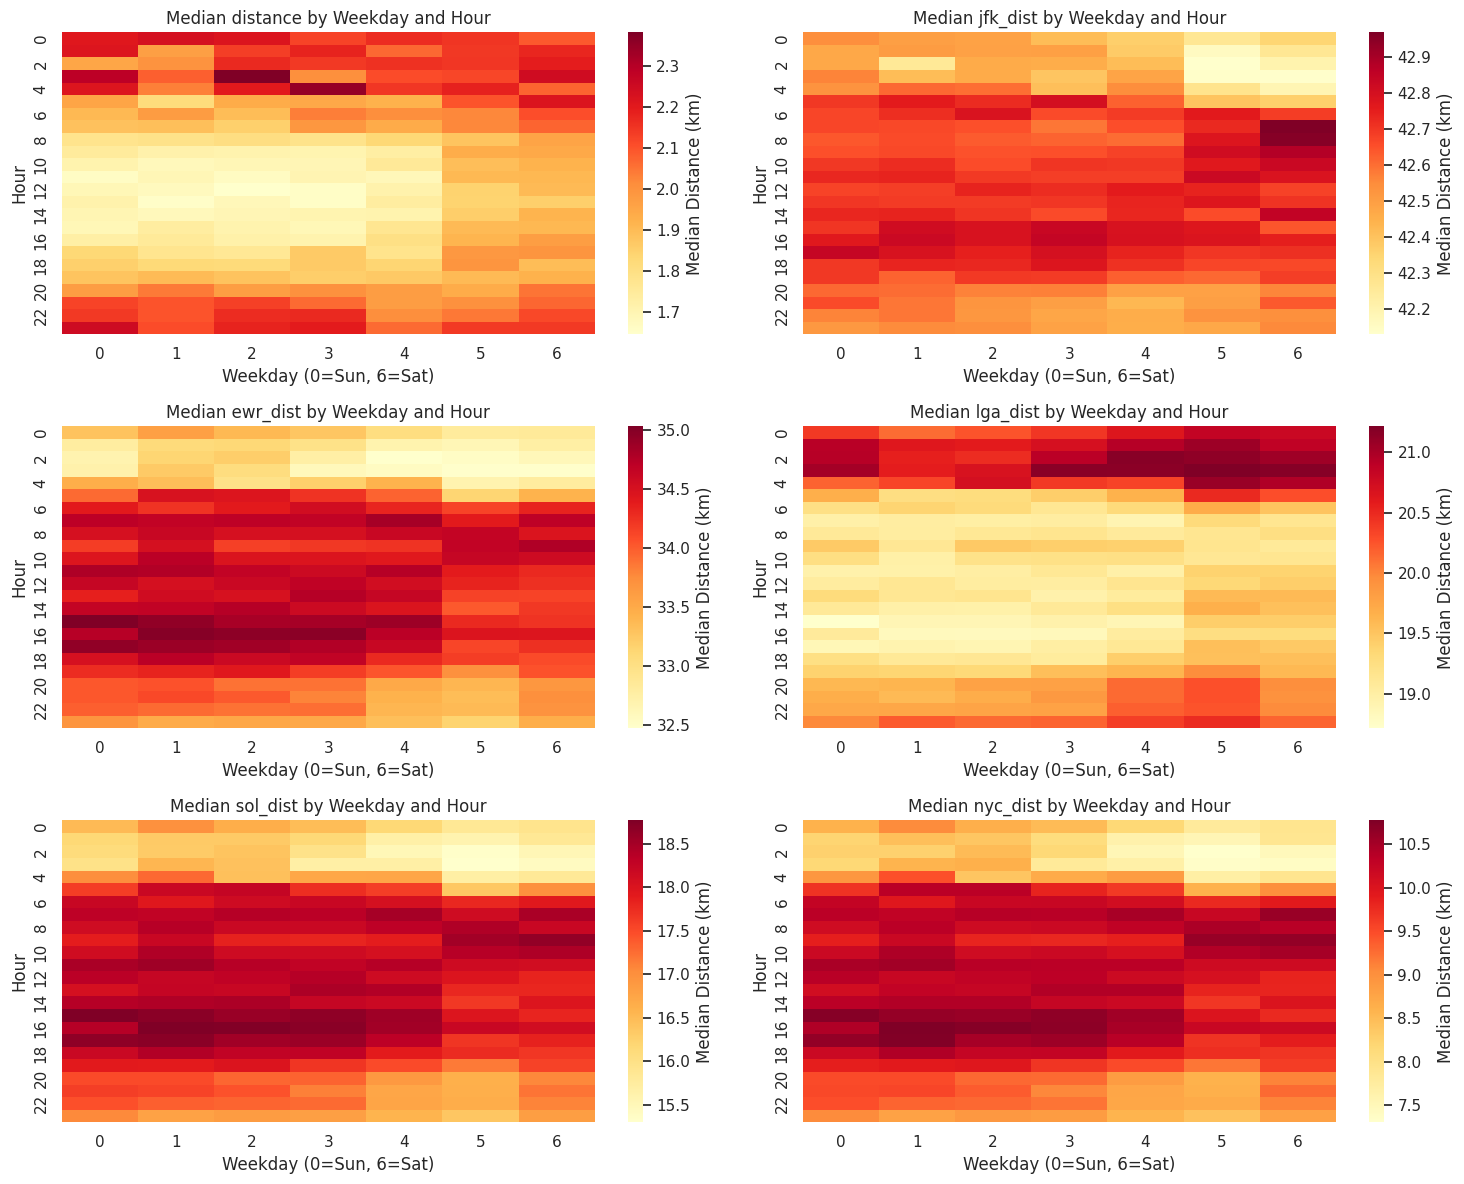

In [62]:
# Define features
dist_features = ['distance', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']

# Create pivot tables for median distances
pivot_tables = {}
for dist in dist_features:
    pivot_tables[dist] = data.pivot_table(values=dist, index='hour', columns='weekday', aggfunc='median')

# Plot setup
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))

# Heatmaps for each distance feature
for i, dist in enumerate(dist_features, 1):
    plt.subplot(3, 2, i)
    sns.heatmap(pivot_tables[dist], cmap='YlOrRd', annot=False, fmt='.1f', cbar_kws={'label': 'Median Distance (km)'})
    plt.title(f'Median {dist} by Weekday and Hour')
    plt.xlabel('Weekday (0=Sun, 6=Sat)')
    plt.ylabel('Hour')

plt.tight_layout()
plt.show()

In [63]:
# Stats for context
print("\nMedian Distance Stats by Weekday and Hour:")
for dist in dist_features:
    print(f"\n{dist}:")
    display(pivot_tables[dist].describe())

# Zero distance insight
zero_dist = data[data['distance'] == 0].shape[0]
print(f"\nNumber of trips with zero distance: {zero_dist}")


Median Distance Stats by Weekday and Hour:

distance:


weekday          0          1          2          3          4          5  \
count    24.000000  24.000000  24.000000  24.000000  24.000000  24.000000   
mean      1.920487   1.884637   1.917833   1.920965   1.906986   1.994365   
std       0.208514   0.172783   0.222040   0.207189   0.157742   0.110823   
min       1.665322   1.656788   1.645842   1.658029   1.686135   1.842920   
25%       1.723517   1.733526   1.710942   1.705545   1.767590   1.903287   
50%       1.882698   1.857639   1.867420   1.906095   1.896672   1.990394   
75%       2.128457   2.033259   2.139720   2.078709   2.023031   2.102857   
max       2.286216   2.232774   2.380807   2.347238   2.165258   2.183552   

weekday          6  
count    24.000000  
mean      2.026769  
std       0.116182  
min       1.854263  
25%       1.919000  
50%       2.022034  
75%       2.109067  
max       2.244020


jfk_dist:


weekday          0          1          2          3          4          5  \
count    24.000000  24.000000  24.000000  24.000000  24.000000  24.000000   
mean     42.645557  42.642603  42.639158  42.621917  42.605626  42.571743   
std       0.093435   0.131751   0.107529   0.141209   0.137846   0.232344   
min      42.470529  42.256989  42.463495  42.391797  42.366117  42.128472   
25%      42.562579  42.586083  42.538815  42.492249  42.476612  42.452708   
50%      42.670742  42.664215  42.655352  42.656400  42.640230  42.665095   
75%      42.697758  42.736329  42.725112  42.708882  42.717204  42.768191   
max      42.837350  42.824282  42.790086  42.841425  42.792456  42.824095   

weekday          6  
count    24.000000  
mean     42.607126  
std       0.241985  
min      42.132696  
25%      42.495942  
50%      42.671420  
75%      42.758240  
max      42.967984


ewr_dist:


weekday          0          1          2          3          4          5  \
count    24.000000  24.000000  24.000000  24.000000  24.000000  24.000000   
mean     34.114381  34.231457  34.158526  34.104413  33.966106  33.737161   
std       0.686655   0.609164   0.631379   0.707303   0.760974   0.738987   
min      32.693153  33.074739  32.969533  32.595503  32.474995  32.491059   
25%      33.866012  33.839553  33.794563  33.728057  33.418181  33.150102   
50%      34.313710  34.497905  34.428842  34.343335  34.264954  34.070086   
75%      34.640000  34.685710  34.617441  34.670330  34.616284  34.348483   
max      35.027230  34.987919  34.952912  34.961284  34.875181  34.658700   

weekday          6  
count    24.000000  
mean     33.846844  
std       0.692978  
min      32.491064  
25%      33.460117  
50%      34.114793  
75%      34.307475  
max      34.768580


lga_dist:


weekday          0          1          2          3          4          5  \
count    24.000000  24.000000  24.000000  24.000000  24.000000  24.000000   
mean     19.574815  19.477840  19.527886  19.589985  19.714755  19.969498   
std       0.674404   0.602535   0.625611   0.691929   0.742003   0.710151   
min      18.714170  18.823782  18.813206  18.832301  18.884988  19.118884   
25%      19.082392  19.010655  19.028933  19.042790  19.100821  19.375464   
50%      19.345027  19.191923  19.293480  19.322114  19.416358  19.685164   
75%      19.799053  19.843976  19.871132  19.937714  20.228375  20.489429   
max      21.025429  20.627783  20.720263  21.164328  21.175414  21.215169   

weekday          6  
count    24.000000  
mean     19.856923  
std       0.666179  
min      19.078041  
25%      19.416471  
50%      19.567916  
75%      20.197008  
max      21.184854


sol_dist:


weekday          0          1          2          3          4          5  \
count    24.000000  24.000000  24.000000  24.000000  24.000000  24.000000   
mean     17.701666  17.834008  17.733832  17.635426  17.461749  17.168495   
std       0.823949   0.770721   0.805929   0.907274   1.003102   1.064488   
min      15.986699  16.329935  16.334152  15.685671  15.505901  15.301627   
25%      17.358534  17.335058  17.185709  17.044452  16.743667  16.376628   
50%      17.989832  18.203620  18.148624  17.981210  17.887909  17.665606   
75%      18.322322  18.407226  18.315623  18.311233  18.316095  18.026224   
max      18.767823  18.765870  18.753924  18.687498  18.547030  18.516164   

weekday          6  
count    24.000000  
mean     17.338217  
std       0.975110  
min      15.420817  
25%      16.943945  
50%      17.729280  
75%      18.007645  
max      18.631717


nyc_dist:


weekday          0          1          2          3          4          5  \
count    24.000000  24.000000  24.000000  24.000000  24.000000  24.000000   
mean      9.726764   9.854456   9.744547   9.645810   9.469218   9.196473   
std       0.792863   0.762627   0.785899   0.891078   1.003422   1.079340   
min       8.184511   8.256682   8.385543   7.807833   7.529432   7.303447   
25%       9.369773   9.426738   9.193088   9.022447   8.748021   8.566465   
50%       9.997949  10.214217  10.155715  10.007509   9.889026   9.684342   
75%      10.348777  10.418394  10.356726  10.345318  10.321388  10.093002   
max      10.731510  10.777544  10.727082  10.682103  10.546301  10.605401   

weekday          6  
count    24.000000  
mean      9.370182  
std       0.997709  
min       7.386194  
25%       8.954065  
50%       9.734195  
75%      10.051307  
max      10.637744


Number of trips with zero distance: 3149


#### Case 7: How do traffic conditions, time, and trip characteristics interplay to affect fare amounts and distances?

We investigate how `Traffic Condition`, combined with time-related features (`year`, `month`, `day`, `weekday`, `hour`), categorical factors (`Car Condition`, `Weather`), and numerical trip characteristics (`fare_amount`, `passenger_count`, `distance`, `jfk_dist`, `ewr_dist`, `lga_dist`, `sol_dist`, `nyc_dist`, `bearing`), influences trip costs and lengths. While geographical coordinates were excluded due to their inconsistency (e.g., global spread vs. NYC expectation), the dataset’s other features suggest a rich context for understanding traffic’s role. With `Traffic Condition` evenly distributed, peaks in time (e.g., Thursday/Friday ~75,000 trips, 6-10 PM rush), and anomalies like zero fares and high zero distances, we hypothesize that heavy traffic increases fares and distances to landmarks, modulated by weather, car state, and time. This case uses heatmaps for traffic-time interactions and a correlation matrix to quantify relationships across all features, aiming to uncover how operational and environmental factors shape trip dynamics.

In [64]:
# Define feature groups
categorical_features = ['Car Condition', 'Weather', 'Traffic Condition']
time_features = ['year', 'month', 'day', 'weekday', 'hour']
numerical_features = ['fare_amount', 'passenger_count', 'distance']
landmark_dists = ['jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']
other_features = ['bearing']
all_features = categorical_features + time_features + numerical_features + landmark_dists + other_features

Text(153.75, 0.5, 'Hour')

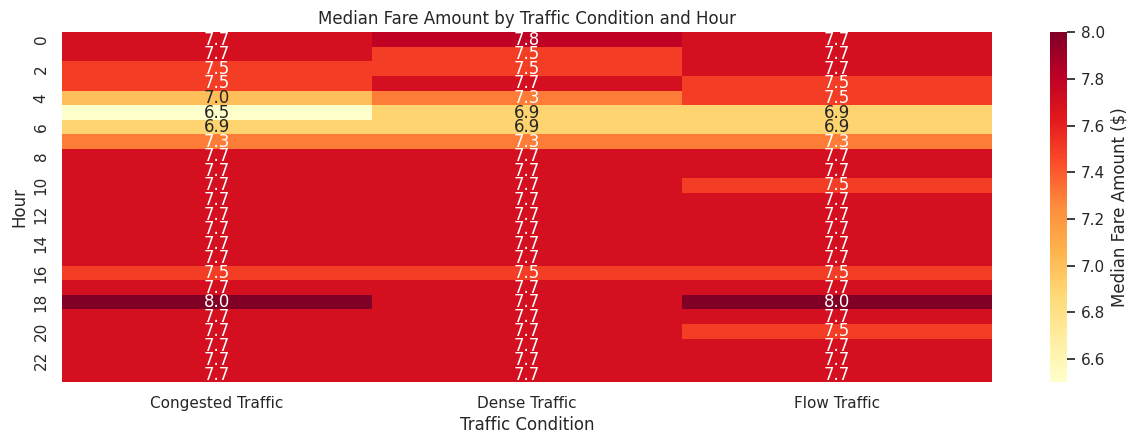

In [65]:
# Traffic Condition vs. Time Heatmap (example with hour and weekday)
pivot_fare = data.pivot_table(values='fare_amount', index='hour', columns='Traffic Condition', aggfunc='median')
pivot_dist = data.pivot_table(values='distance', index='weekday', columns='Traffic Condition', aggfunc='median')

# Plot setup
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Heatmap 1: Fare Amount by Traffic Condition and Hour
plt.subplot(2, 1, 1)
sns.heatmap(pivot_fare, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Median Fare Amount ($)'})
plt.title('Median Fare Amount by Traffic Condition and Hour')
plt.xlabel('Traffic Condition')
plt.ylabel('Hour')

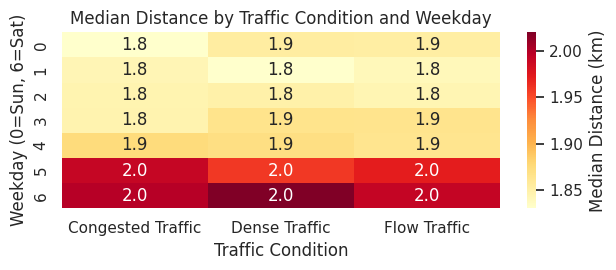

In [66]:
# Heatmap 2: Distance by Traffic Condition and Weekday
plt.subplot(2, 1, 2)
sns.heatmap(pivot_dist, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Median Distance (km)'})
plt.title('Median Distance by Traffic Condition and Weekday')
plt.xlabel('Traffic Condition')
plt.ylabel('Weekday (0=Sun, 6=Sat)')

plt.tight_layout()
plt.show()

In [67]:
# Median stats by Traffic Condition
print("\nMedian Values by Traffic Condition:")
medians = data.groupby('Traffic Condition')[numerical_features + landmark_dists].median()
display(medians)


Median Values by Traffic Condition:


fare_amount  passenger_count  distance   jfk_dist  \
Traffic Condition                                                      
Congested Traffic          7.7              1.0  1.889780  42.642361   
Dense Traffic              7.7              1.0  1.888443  42.640492   
Flow Traffic               7.7              1.0  1.886644  42.648872   

                    ewr_dist   lga_dist   sol_dist  nyc_dist  
Traffic Condition                                             
Congested Traffic  34.137140  19.522716  17.710603  9.713740  
Dense Traffic      34.144461  19.516739  17.722420  9.727146  
Flow Traffic       34.154787  19.512159  17.737672  9.738746


Correlation Matrix (Spearman) Across All Features:


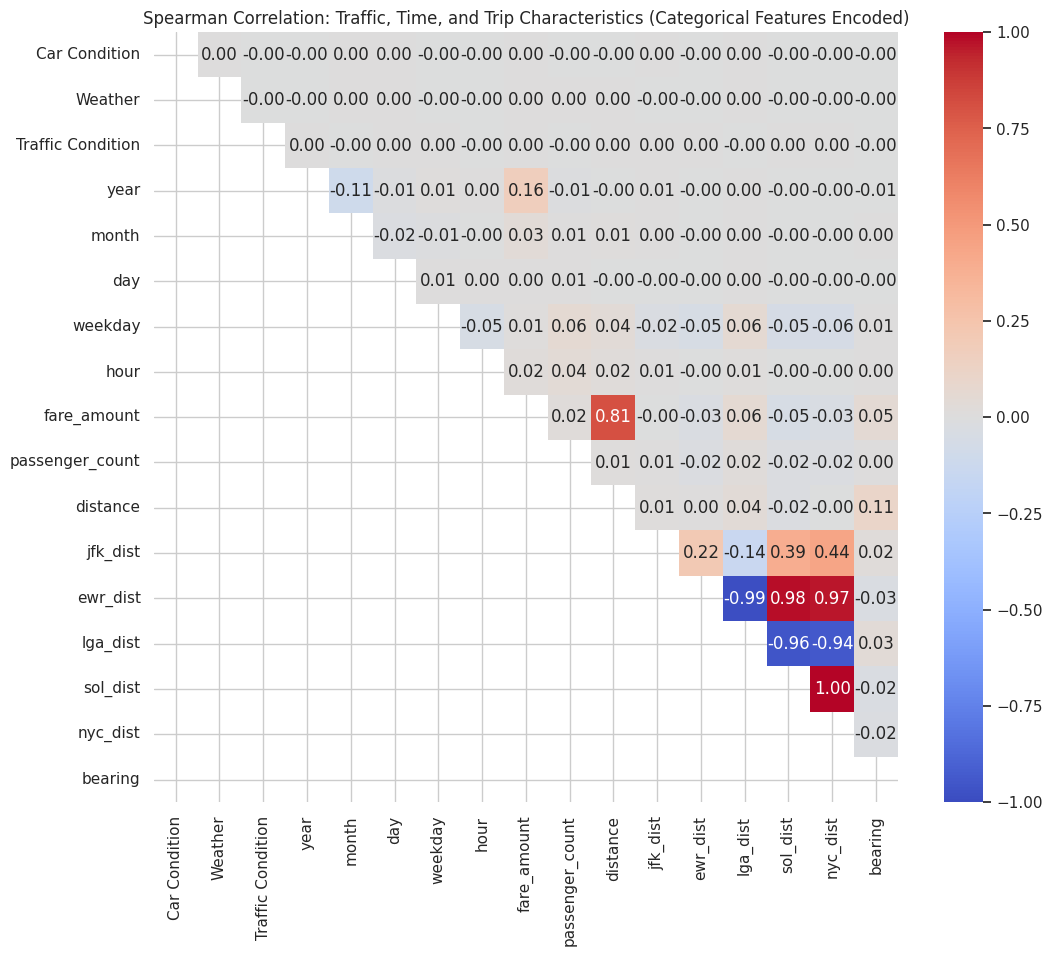

In [68]:
# Create a copy of the data to avoid modifying the original
data_encoded = data[all_features].copy()

# Encode categorical features
le = LabelEncoder()
for cat_feat in categorical_features:
    data_encoded[cat_feat] = le.fit_transform(data_encoded[cat_feat])

# Correlation matrix with heatmap
print("\nCorrelation Matrix (Spearman) Across All Features:")
correlations = data_encoded[all_features].corr(method='spearman')
plt.figure(figsize=(12, 10))
mask = np.tril(np.ones_like(correlations, dtype=bool))
sns.heatmap(correlations, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Spearman Correlation: Traffic, Time, and Trip Characteristics (Categorical Features Encoded)')
plt.show()